# Data preparation

### Read and clean

In [3]:
# Project: Assessing Taiwan's global outbreak intelligence 2009-2025
# Date: 2025-12-25
# Author: Hao-Kai Tseng
#############
import pandas as pd
from utils.data_loader import load_raw_data
from utils.pipeline import run_daily_news_pipeline
from utils.clean_press_data import get_cleaned_press_data
from utils.clean_visitor_data import get_processed_visitor_data

research_end_date = "2025-12-31"
# 1. Define Paths & Parameters
config = {
    "epi_xlsx_path": "data/WWWTable_Epidemics_20251229V1.2_fill_until_20251231.xlsx",
    "tcdc_csv_path": "data/TCDCIntlEpidAll.csv",
    "country_xlsx_path": "data/03輔助用表_監測國家清單.xlsx",
    "transmission_xlsx_path": "data/01總整_01國際疫情資料庫(2017-)_監測疾病清單.xlsx",
    "research_end_date": "2025-12-31" 
}

# 2. Run Pipeline (Performs reading, cleaning, and all mappings)
df  = run_daily_news_pipeline(**config) #, df_raw

# 3. Load auxiliary data for downstream usage
_ , country_mapping, dat_transmission_route_raw, region_mapping = load_raw_data(**config)

print(f"Data processing complete. Processed {len(df)} rows for df.")

# 4. Clean Visitor Data
from utils.clean_visitor_data import get_processed_visitor_data
df_visit_by_year_flat, df_visit_flat_all_years = get_processed_visitor_data('data/表1-2-歷年來臺旅客按居住地分.xlsx', n_top_countries_selected=15)

# 5. Clean Press Data
df_press = get_cleaned_press_data('data/新聞稿_20251229_fill_until_20251231.xlsx', research_end_date = '2025-12-31')

# 6. Clean Alert Data
from utils.alert import get_combined_travel_alerts
df_alert_all = get_combined_travel_alerts()

Data processing complete. Processed 73344 rows for df.


c:\Users\three\Neu Kasten_5440\029 CDC EIC\cdc_eic_daily_news\utils\alert.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(
c:\Users\three\Neu Kasten_5440\029 CDC EIC\cdc_eic_daily_news\utils\alert.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(
c:\Users\three\Neu Kasten_5440\029 CDC EIC\cdc_eic_daily_news\utils\alert.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org

### List of top n diseases
For graph 2 summary

In [23]:
list_common_diseases = df['disease_name'].value_counts().head(19).index
list_common_diseases_en = df['disease_name_en'].value_counts().head(19).index
print(list_common_diseases)

# percentage table
all_disease_counts = df['disease_name'].value_counts()
disease_percentage = all_disease_counts / df.shape[0] * 100  # Multiply by 100 to get percentage
disease_percentage = disease_percentage.round(2)
# Combine counts and percentages into a new DataFrame
table_all_disease_count_percentage = pd.DataFrame({
    'Count': all_disease_counts,
    'Percentage': disease_percentage
})

top_10_diseases = table_all_disease_count_percentage.head(30)

# Format the output for each disease using regular expressions
formatted_output = []
for disease, row in top_10_diseases.iterrows():
    count = row['Count']
    percentage = row['Percentage']
    formatted_output.append(f"{disease}({count}次；{percentage:.2f}%)")

# Print the formatted output
for disease_info in formatted_output:
    print(disease_info)




Index(['新型A型流感', 'COVID-19', '登革熱', '小兒麻痺症', '麻疹', '流感', 'M痘', '禽類禽流感', '霍亂',
       '伊波拉病毒感染', '茲卡病毒感染症', '腸病毒', '屈公病', '兒童急性嚴重不明原因肝炎', '沙門氏菌感染症', '瘧疾',
       '中東呼吸症候群冠狀病毒感染症', '黃熱病', '狂犬病'],
      dtype='object', name='disease_name')
新型A型流感(28441.0次；39.25%)
COVID-19(6309.0次；8.71%)
登革熱(4321.0次；5.96%)
小兒麻痺症(3551.0次；4.90%)
麻疹(3082.0次；4.25%)
流感(2243.0次；3.10%)
M痘(1891.0次；2.61%)
禽類禽流感(1885.0次；2.60%)
霍亂(1592.0次；2.20%)
伊波拉病毒感染(1192.0次；1.64%)
茲卡病毒感染症(1094.0次；1.51%)
腸病毒(1032.0次；1.42%)
屈公病(844.0次；1.16%)
兒童急性嚴重不明原因肝炎(821.0次；1.13%)
沙門氏菌感染症(695.0次；0.96%)
瘧疾(648.0次；0.89%)
中東呼吸症候群冠狀病毒感染症(645.0次；0.89%)
黃熱病(629.0次；0.87%)
狂犬病(477.0次；0.66%)
西尼羅熱(441.0次；0.61%)
退伍軍人病(423.0次；0.58%)
百日咳(386.0次；0.53%)
流行性腦脊髓膜炎(336.0次；0.46%)
炭疽病(329.0次；0.45%)
克里米亞-剛果出血熱(322.0次；0.44%)
急性病毒性A型肝炎(316.0次；0.44%)
大腸桿菌(307.0次；0.42%)
拉薩熱(291.0次；0.40%)
鉤端螺旋體病(263.0次；0.36%)
白喉(258.0次；0.36%)


# Global map

In [3]:
import plotly.express as px
import pandas as pd
import numpy as np
import kaleido

n_top_countries = 15 

df_country_counts = (
    df.groupby("country_iso3")
      .size()
      .reset_index(name="n_reports")
      .sort_values("n_reports", ascending=False))

#print(df_country_counts.head(15))
q1 = df_country_counts["n_reports"].quantile(0.25)
q2 = df_country_counts["n_reports"].quantile(0.5)
q3 = df_country_counts["n_reports"].quantile(0.75)
print(f"Q1 Q2 Q3: {q1}, {q2}, {q3}")

top_travelling_iso3 = (
    df_visit_flat_all_years["iso3"] #from visitor data
    .dropna()
    .explode()          
    .unique()
    .tolist()
)
print(top_travelling_iso3)

df_country_counts["is_top_travelling"] = (
    df_country_counts["country_iso3"].isin(top_travelling_iso3)
)

# define reporting levels
bins = [0, 100, 300, 1000, float("inf")]
labels = [
    "1–100",
    "101-300",
    "301–1000",
    ">1000"]

df_country_counts["level"] = pd.cut(
    df_country_counts["n_reports"],
    bins=bins,
    labels=labels
)

# plotting
fig = px.choropleth(
    df_country_counts,
    locations="country_iso3",
    color="level",
    projection="equirectangular",#natural earth
    category_orders={"level": labels},
    color_discrete_sequence = [
    "#f7fbff",  # very low
    "#c6dbef",  # low
    "#fdae6b",  # medium
    "#e6550d"],
    title="國際重要疫情資訊疫情發生國家/地區(2009-2025年)"
)

overlay_df = df_country_counts[df_country_counts["is_top_travelling"]].copy()

# --- Force-marker coordinates for special/small/centroid-problem locations ---
special_points = {
    "HKG": (22.3193, 114.1694),   # Hong Kong
    "SGP": (1.3521, 103.8198),    # Singapore
    "MYS": (4.2105, 101.9758),    # Malaysia (peninsular center-ish)
}

overlay_special = overlay_df[overlay_df["country_iso3"].isin(special_points.keys())].copy()
overlay_normal  = overlay_df[~overlay_df["country_iso3"].isin(special_points.keys())].copy()

fig.add_scattergeo(
    locations=overlay_normal["country_iso3"],
    locationmode="ISO-3",
    mode="markers",
    marker=dict(
    symbol="star",
    size=8.5,
    color="yellow",
    line=dict(color="black", width=0.9),
    opacity=0.85),
    name="主要來臺旅客居住地",
    showlegend=True
)

if not overlay_special.empty:
    overlay_special["lat"] = overlay_special["country_iso3"].map(lambda c: special_points[c][0])
    overlay_special["lon"] = overlay_special["country_iso3"].map(lambda c: special_points[c][1])

    fig.add_scattergeo(
        lat=overlay_special["lat"],
        lon=overlay_special["lon"],
        mode="markers",
        marker=dict(symbol="star", size=8.5, color="yellow", line=dict(color="black", width=0.9), opacity=0.85),
        showlegend=False
    )

fig.update_layout(
    width=700,
    height=350,  
    margin=dict(l=0, r=0, t=30, b=0),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        x=0.06, y=0.02,            # bottom-left
        xanchor="left", yanchor="bottom",
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="rgba(0,0,0,0.1)",
        borderwidth=0.4,
        title="資訊則數",
        font=dict(size=10))
)

fig.update_geos(
    projection_type="equirectangular",
    showframe=False,              # remove geo frame
    showcoastlines=False,
    showcountries=True,
    countrycolor="rgba(0,0,0,0.15)",
    showland=True,
    landcolor="white",
    showocean=False,
    showlakes=False,
    bgcolor="rgba(0,0,0,0)",      # transparent geo background
    lataxis_range=[-60, 85]
)

fig.show()

fig.write_html("output/plot_publication/global_map.html")


Q1 Q2 Q3: 57.0, 207.0, 352.0
['CHN', 'JPN', 'HKG', 'KOR', 'USA', 'MYS', 'SGP', 'VNM', 'PHL', 'THA', 'IDN', 'CAN', 'AUS', 'GBR', 'DEU']


# Table 1 - simplified overview table
including gemini press analysis, 

## Using Gemini api to analysis press data

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import concurrent.futures
from tqdm import tqdm
from google import genai
from google.genai import types

# 初始化 Client（需先設定好 GOOGLE_API_KEY 環境變數）
client = genai.Client()

MAX_WORKERS = 15           # RPM
DAILY_LIMIT = 10000        # 每日請求上限（保護額度）

SYSTEM_INSTRUCTION = (
    "你是一位臺灣疾病管制署的流行病學家，你的分類任務是判斷新聞稿內容是否提及國際疫情，例如全球、區域、台灣以外國家的疫情，只回覆'1'(是)或'0'(否)。"
)

MODEL_NAME = "gemini-2.5-flash"

def flag_international_with_gemini(text: str) -> str:
    if not isinstance(text, str) or text.strip() == "":
        return "0"

    prompt = f"內容：{text}"

    max_retries = 5
    base_delay = 1

    for attempt in range(max_retries):
        try:
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt,
                config=types.GenerateContentConfig(
                    system_instruction=SYSTEM_INSTRUCTION,
                    temperature=0.0,
                    max_output_tokens=5
                )
            )
            clean_result = (response.text or "").strip()
            if clean_result in ("1", "0"):
                return clean_result
            return "ERROR"

        except Exception:
            if attempt < max_retries - 1:
                time.sleep(base_delay * (2 ** attempt))
            else:
                return "ERROR"

    return "ERROR"


# =========================
# 1) data preparation
# =========================
df_gemini = df_press.copy()

df_gemini["PublishTime"] = pd.to_datetime(df_gemini["PublishTime"], errors="coerce")

df_gemini["year"] = df_gemini["PublishTime"].dt.year

# 清理文字：把 Subject + Content 合併
df_gemini["Subject"] = df_gemini["Subject"].fillna("").astype(str).str.strip()
df_gemini["Content"] = df_gemini["Content"].fillna("").astype(str).str.strip()
df_gemini["subject_content"] = (df_gemini["Subject"] + "。 " + df_gemini["Content"]).str.strip()

# time range settings: 
# df_gemini = df_gemini[df_gemini["PublishTime"] >= "2025-01-01"].copy()
 
total_rows = len(df_gemini)
print(f"--- 準備處理資料筆數: {total_rows} ---")

# =========================
# 2) 每日額度安全檢查
# =========================
if total_rows > DAILY_LIMIT:
    print(f"⚠️ 警告: 資料量 ({total_rows}) 超過每日限制 ({DAILY_LIMIT})，將截斷至前 {DAILY_LIMIT} 筆。")
    df_gemini = df_gemini.head(DAILY_LIMIT).copy()
else:
    print("資料量在每日額度內，將全數處理。")

# =========================
# 3) 並行處理
# =========================
print(f"\n--- 開始分類 (Workers: {MAX_WORKERS}) ---")

def process_task(task_tuple):
    idx, text = task_tuple
    res = flag_international_with_gemini(text)
    return idx, res

tasks = list(zip(df_gemini.index, df_gemini["subject_content"]))
results_dict = {}

start_time = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(process_task, t): t for t in tasks}

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(tasks), desc="Classifying"):
        try:
            idx, res = future.result()
            results_dict[idx] = res
        except Exception as e:
            # 這裡如果 thread 本身炸掉，保底記 ERROR
            t = futures.get(future, None)
            if t is not None:
                idx = t[0]
                results_dict[idx] = "ERROR"

end_time = time.time()
duration = end_time - start_time
print(f"\n✅ 處理完成。耗時: {duration:.2f} 秒。")
print(f"平均速度: {len(tasks)/duration:.2f} RPS (約 {(len(tasks)/duration)*60:.0f} RPM)")

# =========================
# 4) 整合結果
# =========================
df_gemini["flag_international_outbreak"] = df_gemini.index.map(results_dict)

# 轉成數值（ERROR 一律當 0 或你想保留 NaN 都可）
df_gemini["flag_international_outbreak"] = df_gemini["flag_international_outbreak"].apply(
    lambda x: int(x) if x in ("1", "0") else 0
)

print("\n--- 前 10 筆結果預覽 ---")
print(df_gemini[["PublishTime", "Subject", "flag_international_outbreak"]].head(3))

# =========================
# 5) 年度統計
# =========================
table_press_international = (
    df_gemini
    .groupby("year")
    .agg(
        count_international=("flag_international_outbreak", "sum"),
        count_total=("flag_international_outbreak", "size")
    )
    .assign(
        perc_international=lambda x: (
            x["count_international"] / x["count_total"] * 100
        ).round(0).astype(int)
    )
    .reset_index()
)

print("\n--- 年度統計 ---")
print(table_press_international)

table_press_international.to_csv("output/table_publication/table_press_gemini_international.csv", index=False)

--- 準備處理資料筆數: 228 ---
資料量在每日額度內，將全數處理。

--- 開始分類 (Workers: 15) ---


Classifying: 100%|██████████| 228/228 [00:14<00:00, 15.96it/s]


✅ 處理完成。耗時: 14.33 秒。
平均速度: 15.91 RPS (約 955 RPM)

--- 前 10 筆結果預覽 ---
     PublishTime                                            Subject  \
7095  2025-01-01  114年啟動「國家級防疫一體抗生素抗藥性管理行動計畫」，以防疫一體(One Health)為...   
7096  2025-01-07    農曆春節將至，民眾出國旅遊及往來頻繁，請符合資格民眾儘速接種流感及新冠疫苗，保障自身與家人健康   
7098  2025-01-07       國內腸病毒疫情下降，惟仍處於流行期，提醒民眾持續保持良好衛生習慣，落實手部衛生與環境清消   

      flag_international_outbreak  
7095                            0  
7096                            1  
7098                            0  

--- 年度統計 ---
   year  count_international  count_total  perc_international
0  2025                   84          228                  37


## Metrics calculation

### Overall

In [54]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.to_datetime(df['date']).dt.year # not using iso week df['year'] = df['date'].dt.isocalendar().year
df['week_number'] = df['date'].dt.isocalendar().week

# 平均每週國家疾病數
weekly_country_disease_counts = df.groupby(['year', 'week_number']).size().reset_index(name='平均每週國家疾病數')
mean_weekly_country_disease_counts = weekly_country_disease_counts.groupby('year')['平均每週國家疾病數'].mean().round(0).astype(int).reset_index()

# 當年國家疾病總數(重複)
#annual_country_disease_counts = df.groupby(['year'])['country_disease'].nunique().reset_index(name = '年度國家疾病總數(非重複)')
annual_country_disease_counts = df.groupby(['year'])['country_disease'].size().reset_index(name = '國際重要疫情-國家疾病則數')

# 不明原因疾病 & 不明原因致死疾病
df_unknown_d_combined = df[df['disease_name'].isin(["不明原因疾病", "不明原因致死疾病"])]
table_unknown_d_total = (
    df_unknown_d_combined.groupby(df_unknown_d_combined['date'].dt.year)
    .size()
    .reset_index(name='國際重要疫情-不明原因疾病則數'))
table_unknown_d_total.rename(columns={'date': 'year'}, inplace=True)

# 時效性 based on utils/timeliness.py
from utils.timeliness import get_table_timeliness_by_year
table_timeliness_byyear = get_table_timeliness_by_year(df)
table_timeliness_byyear_median = table_timeliness_byyear[["year","median_interval"]].round().astype(int).rename(
    columns={"median_interval": "國際重要疫情-時效性"} )

# 國際疫情佔新聞稿數佔比
df_press_international = pd.read_csv('output/table_publication/table_press_gemini_international.csv')
df_press_international =df_press_international.drop(columns=['count_total'])
df_press_international = df_press_international.rename(columns={'count_international': '新聞稿-含國際疫情則數'})
df_press_international = df_press_international.rename(columns={'perc_international': '新聞稿-含國際疫情佔比(%)'})

# 旅遊疫情建議等級
df_alert_all['year'] = pd.to_datetime(df_alert_all['date']).dt.year
df_alert_all_level123 = df_alert_all[df_alert_all['severity_level'] != '解除']
table_alert_count = df_alert_all_level123.groupby(['year']).size().reset_index(name='國際旅遊疫情建議等級-公告數')

# 當年國家總數(非重複)
# # 當年疾病總數(非重複)
# 當年資料來源數量(非重複) ( use df_raw instead of df)

############################
### Merging master table ###
############################
# summary_table_1 = pd.merge(mean_weekly_country_disease_counts, annual_country_disease_counts, 
#                            on='year', how='outer') 
summary_table_1 = pd.merge(annual_country_disease_counts, table_unknown_d_total, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_timeliness_byyear_median, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_alert_count, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, df_press_international, 
                           on='year', how='outer')

# Display the result
print(summary_table_1.tail(3))
summary_table_1.to_excel("output/table_publication/Table_1_summary_statistics.xlsx")

    year  國際重要疫情-國家疾病則數  國際重要疫情-不明原因疾病則數  國際重要疫情-時效性  國際旅遊疫情建議等級-公告數  \
14  2023           2520               18           6           402.0   
15  2024           2610               19           7           186.0   
16  2025           2802               13           3           276.0   

    新聞稿-含國際疫情則數  新聞稿-含國際疫情佔比(%)  
14           96              24  
15           78              26  
16           84              37  


In [ ]:
### cross-year mean and standard deviation ###
# Initialize dictionaries to store standard deviations and means
std_devs = {}
means = {}

# Loop through each column to calculate standard deviation and mean
for column in summary_table_1.columns[0:]:
    std_devs[column] = summary_table_1[column].std().round(0).astype(int)
    means[column] = summary_table_1[column].mean().round(0).astype(int)

summary_table_1.loc['Mean'] = means
summary_table_1.loc['Standard Deviation'] = std_devs

summary_table_1['year'] = summary_table_1['year'].astype(str)
summary_table_1.loc['Mean', 'year'] = '平均'
summary_table_1.loc['Standard Deviation', 'year'] = '標準差'

# 確保這一欄是數值（NaN 保留）for plotting
summary_table_numeric = summary_table_1.copy()
summary_table_numeric["國際旅遊疫情建議等級-公告數"] = (
    pd.to_numeric(
        summary_table_numeric["國際旅遊疫情建議等級-公告數"],
        errors="coerce"
    )
)

summary_table_display = summary_table_1.copy()

col = "國際旅遊疫情建議等級-公告數"

summary_table_display[col] = (
    summary_table_display[col]
    .round(0)
    .astype("Int64")
    .astype("object")
    .where(summary_table_display[col].notna(), "-")
)

col = "國際重要疫情-國家疾病則數"
summary_table_display[col] = (
    summary_table_display[col]
    .apply(
        lambda x: f"{int(x):,}"
        if pd.notna(x) and str(x).replace('.', '').isdigit()
        else x
    )
)

print(summary_table_display.tail(3))

                    year 國際重要疫情-國家疾病則數  國際重要疫情-不明原因疾病則數  國際重要疫情-時效性  \
0                   2009        20,007                5           1   
1                   2010        11,513                2           1   
2                   2011         3,626                3           1   
3                   2012         2,761               14           2   
4                   2013         2,325               11           3   
5                   2014         2,605               12           3   
6                   2015         2,072               11           2   
7                   2016         2,418               12           2   
8                   2017         2,618               24           3   
9                   2018         1,569               13           3   
10                  2019         2,032               22           3   
11                  2020         3,221               16           2   
12                  2021         3,134                8           2   
13    

C:\Users\three\AppData\Local\Temp\ipykernel_16680\1884696092.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(CMAP_NAME, LEVELS)


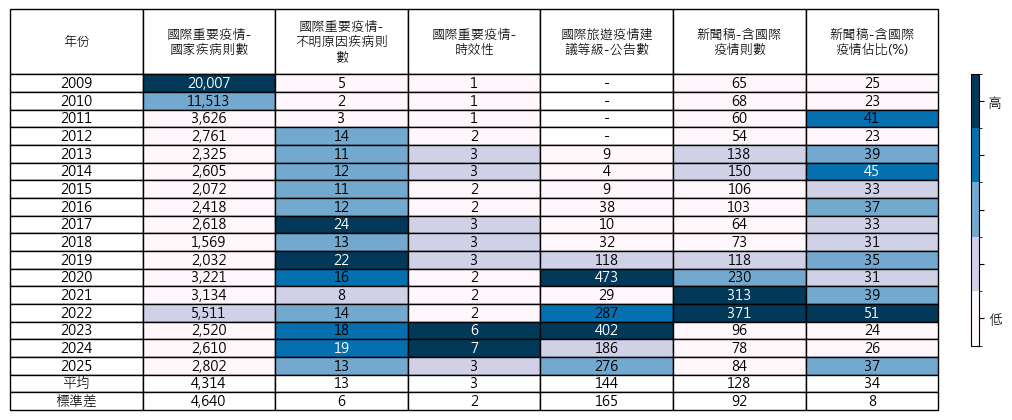

In [56]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.sans-serif'] = [
    'Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'sans-serif'
]

# =========================
# 可調參數
# =========================
CMAP_NAME = 'PuBu'
LEVELS = 5   # 5 階色階（最暗兩階 → 白字）

cmap = plt.cm.get_cmap(CMAP_NAME, LEVELS)

# =========================
# 顏色矩陣初始化（全白）
# =========================
n_rows, n_cols = summary_table_display.shape
cell_colors = np.full((n_rows, n_cols), 'white', dtype=object)

# =========================
# 各欄 Normalize（用 numeric 表）
# =========================
col_norms = [None] * n_cols

for col_idx in range(1, n_cols):  # 跳過 year 欄
    col_values = summary_table_numeric.iloc[:-2, col_idx]  # 排除 Mean / SD
    col_values = pd.to_numeric(col_values, errors="coerce")

    if col_values.notna().sum() == 0:
        continue

    norm = plt.Normalize(col_values.min(), col_values.max())
    col_norms[col_idx] = norm

    # 填顏色
    for row_idx in range(n_rows):
        if summary_table_numeric.index[row_idx] in ['Mean', 'Standard Deviation']:
            continue

        val = summary_table_numeric.iloc[row_idx, col_idx]
        if pd.isna(val):
            continue

        t = norm(val)
        cell_colors[row_idx, col_idx] = cmap(t)

# =========================
# 建立圖表
# =========================
fig, ax = plt.subplots(figsize=(11.5, 4))
ax.axis('off')

# 欄名換行
labels = list(summary_table_display.columns)
labels[0] = '年份'

def wrap_cjk(s, width=7):
    s = str(s)
    return "\n".join(s[i:i+width] for i in range(0, len(s), width))

wrapped_col_labels = [labels[0]] + [wrap_cjk(c) for c in labels[1:]]

# 表格（顯示用 display 表）
table = ax.table(
    cellText=summary_table_display.values,
    colLabels=wrapped_col_labels,
    cellLoc='center',
    loc='center',
    cellColours=cell_colors
)

# =========================
# Colorbar（右側）
# =========================
boundaries = np.linspace(0, 1, LEVELS + 1)
norm_legend = mpl.colors.BoundaryNorm(boundaries, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_legend)
sm.set_array([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=1.1)

tick_centers = (boundaries[:-1] + boundaries[1:]) / 2
cbar = fig.colorbar(sm, cax=cax, ticks=tick_centers)
cbar.ax.set_yticklabels(['低', '', '', '', '高'])

# =========================
# 深色格 → 白字
# =========================
dark_threshold = LEVELS - 2

for col_idx in range(1, n_cols):
    norm = col_norms[col_idx]
    if norm is None:
        continue

    for row_idx in range(n_rows):
        if summary_table_numeric.index[row_idx] in ['Mean', 'Standard Deviation']:
            continue

        val = summary_table_numeric.iloc[row_idx, col_idx]
        if pd.isna(val):
            continue

        t = float(norm(val))
        level_idx = int(np.floor(t * (LEVELS - 1) + 1e-9))

        txt = table[(row_idx + 1, col_idx)].get_text()
        txt.set_color('white' if level_idx >= dark_threshold else 'black')

# =========================
# 字體與版面
# =========================
body_fs = 10 #font size
header_fs = 9.5

table.auto_set_font_size(False)
table.set_fontsize(body_fs)

for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.get_text().set_fontsize(header_fs)
        cell.set_height(0.2)

table.scale(1.2, 1.2)

# 若需特定欄寬
# for (r, c), cell in table.get_celld().items():
#     if c == 10:
#         cell.set_width(0.14)

fig.subplots_adjust(bottom=0.20)

plt.savefig(
    "output/plot_publication/Table_1_summary_statistics.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()


#  Diseases Visualisations

### Disease stacked area chart Mandarin

C:\Users\three\AppData\Local\Temp\ipykernel_30796\3185074314.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_diseases_trend = [cm.get_cmap('tab20')(i) for i in range(len(order_zh))]


<Figure size 1400x700 with 0 Axes>

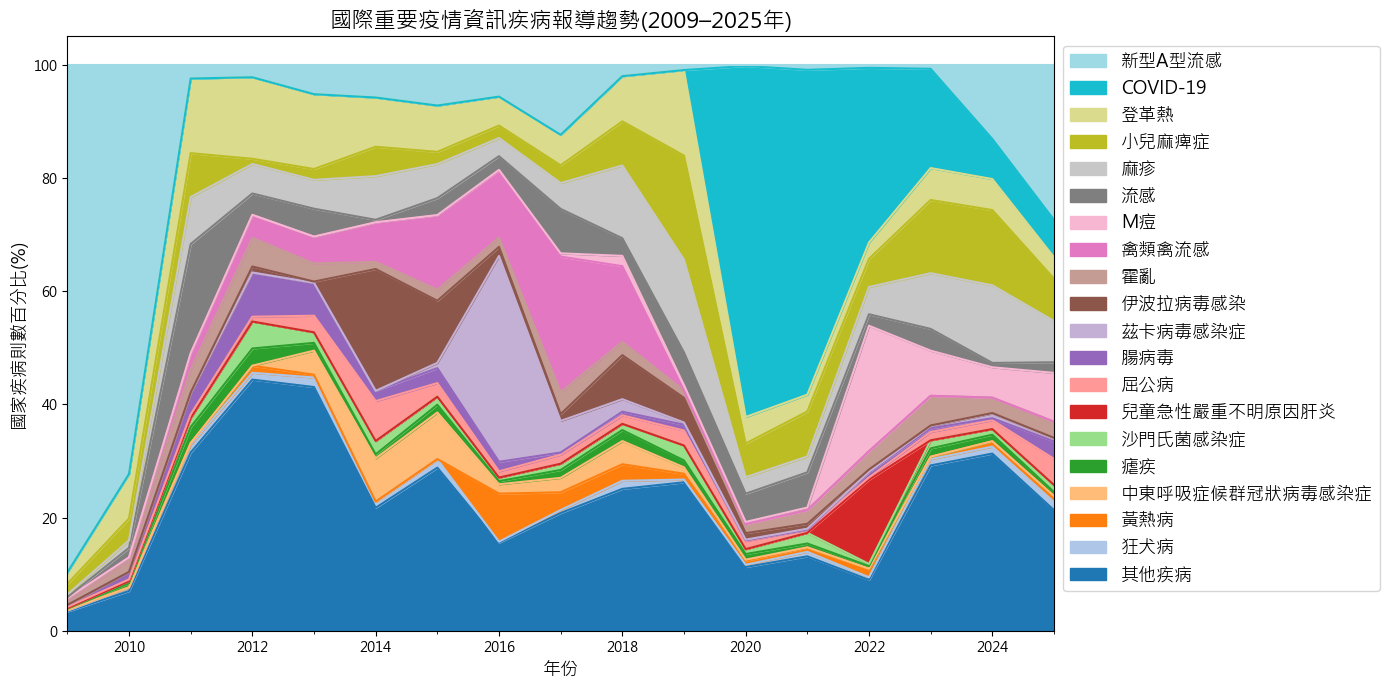

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib import cm
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# Step 1: Categorize diseases not in list_common_diseases as 'Others'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else '其他疾病'
)

#  Step 2: Group by year and grouped disease name
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Y'), 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

#  Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

#  Step 4: Determine order for plotting and legend
total_counts = df_pivot.sum(axis=0).sort_values(ascending=False)
if '其他疾病' in total_counts.index:
    total_counts = pd.concat([total_counts.drop('其他疾病'), pd.Series({'其他疾病': 0})])

order_zh = total_counts.index.tolist()  # Most cases first, "Others" at the end

#  Step 5: Plot stacked area chart (reverse columns for top-down stacking)
plt.figure(figsize=(14, 7))
colors_diseases_trend = [cm.get_cmap('tab20')(i) for i in range(len(order_zh))]
df_percent[order_zh[::-1]].plot(
    kind='area',
    stacked=True,
    figsize=(14, 7),
    color=colors_diseases_trend
)

plt.ylabel('國家疾病則數百分比(%)', fontsize=13)
plt.title('國際重要疫情資訊疾病報導趨勢(2009–2025年)', fontsize=16)
plt.xlabel('年份', fontsize=13)

# Reverse legend order to match plot stacking (top disease at the top)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1),
            fontsize=13)

plt.tight_layout()



plt.savefig("output/plot/disease_proportion_annual_trend.png", dpi=300)
plt.show()



#### Disease stacked area chart English

C:\Users\three\AppData\Local\Temp\ipykernel_30796\2382603638.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_diseases_trend = [cm.get_cmap('tab20')(i) for i in range(len(order))]


<Figure size 1400x700 with 0 Axes>

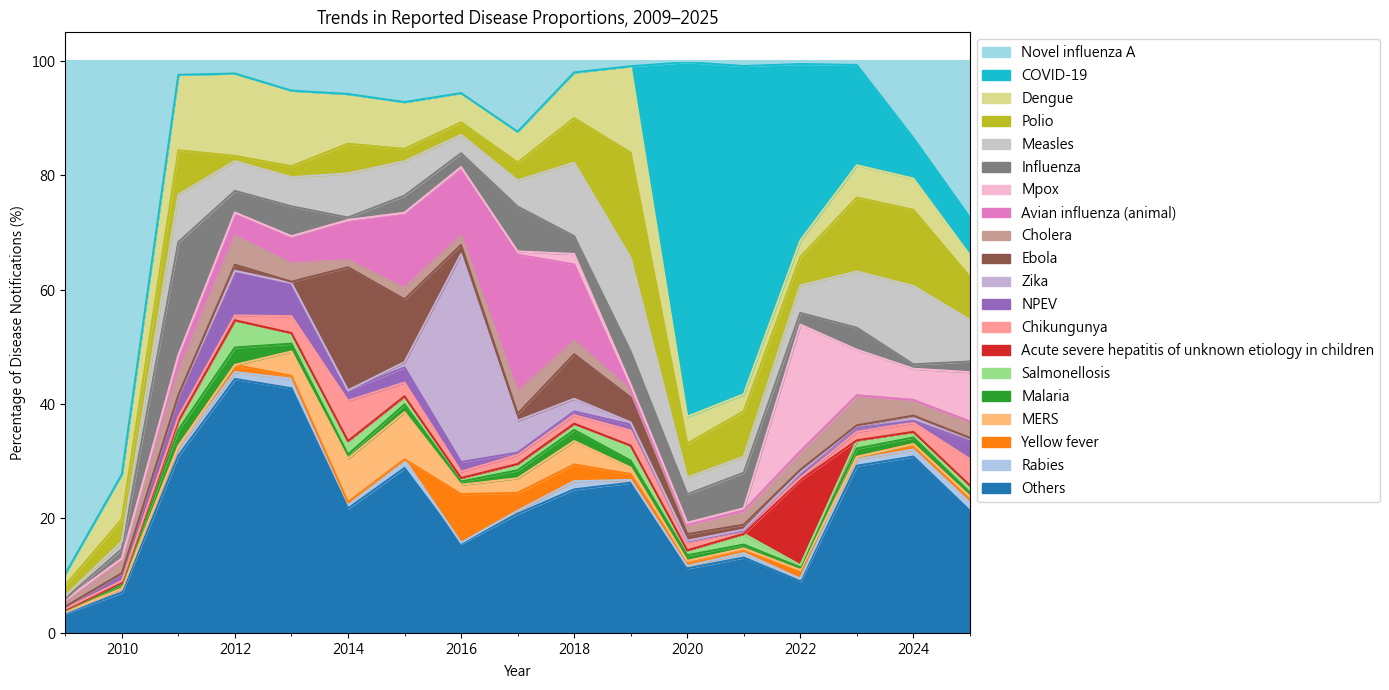

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib import cm
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# Step 1: Categorize diseases not in list_common_diseases as 'Others'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name_en'].apply(
    lambda x: x if x in list_common_diseases_en else 'Others'
)

#  Step 2: Group by year and grouped disease name
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Y'), 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

#  Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

#  Step 4: Determine order for plotting and legend
total_counts = df_pivot.sum(axis=0).sort_values(ascending=False)
if 'Others' in total_counts.index:
    total_counts = pd.concat([total_counts.drop('Others'), pd.Series({'Others': 0})])

order = total_counts.index.tolist()  # Most cases first, "Others" at the end

#  Step 5: Plot stacked area chart (reverse columns for top-down stacking)
plt.figure(figsize=(14, 7))
colors_diseases_trend = [cm.get_cmap('tab20')(i) for i in range(len(order))]
df_percent[order[::-1]].plot(
    kind='area',
    stacked=True,
    figsize=(14, 7),
    color=colors_diseases_trend
)

plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Trends in Reported Disease Proportions, 2009–2025')
plt.xlabel('Year')

# Reverse legend order to match plot stacking (top disease at the top)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


plt.savefig("output/plot/disease_proportion_annual_trend_en.png", dpi=300)
plt.show()


### Disease Sunky bump plot

In [14]:
# sanky bump 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# 🟢 Assume your df already loaded
df_plot = df.copy()
list_common_diseases = df_plot['disease_name'].value_counts().nlargest(15).index.tolist()

# 🟢 Grouping
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_plot['year'] = df_plot['date'].dt.year

# 🟢 Count + Percent
df_counts = (
    df_plot.groupby(['year', 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

df_total = df_counts.groupby('year')['count'].sum().reset_index(name='total')
df_counts = df_counts.merge(df_total, on='year')
df_counts['percent'] = df_counts['count'] / df_counts['total'] * 100

# 🟢 Rank (lower is more frequent)
df_counts['rank'] = df_counts.groupby('year')['count'].rank(ascending=False, method='first')

# 🟢 Assign colors by default order
unique_diseases = df_counts['disease_grouped'].unique()
colors = px.colors.qualitative.Bold + px.colors.qualitative.Safe
color_map = {d: colors[i % len(colors)] for i, d in enumerate(unique_diseases)}

# 🟢 Plot
fig = go.Figure()

for disease in unique_diseases:
    df_d = df_counts[df_counts['disease_grouped'] == disease]
    fig.add_trace(go.Scatter(
        x=df_d['year'],
        y=df_d['rank'],
        mode='lines+markers',
        name=disease,
        line=dict(width=3, color=color_map[disease]),
        marker=dict(
            size=df_d['percent'],
            sizemode='area',
            sizeref=2.*max(df_counts['percent'])/(40.**2),
            sizemin=4,
            color=color_map[disease],
            line=dict(width=0.5, color='black')
        ),
        text=[
            f"{disease}<br>{year}<br>{round(p,1)}%" for disease, year, p in zip(
                df_d['disease_grouped'], df_d['year'], df_d['percent'])
        ],
        hoverinfo='text'
    ))

fig.update_yaxes(
    title='Ranking (Top = 1)',
    autorange='reversed',
    dtick=1,
    tickmode='linear'
)
fig.update_xaxes(
    title='Year',
    tickmode='linear',
    dtick=1
)

fig.update_layout(
    title=dict(
        text="Disease Notification Stream: Ranked Trends by Year",
        font=dict(size=24)
    ),
    font=dict(size=14, family='Microsoft JhengHei'),
    legend=dict(
        title='Disease',
        font=dict(size=14),
        traceorder='normal',
        bgcolor='rgba(255,255,255,0.7)'
    ),
    margin=dict(l=40, r=240, t=60, b=60),
    width=1100,
    height=700
)

fig.show()


### Top disease name heatmap

#### Top3 disease name heat map in Mandarin

['其他疾病', '狂犬病', '黃熱病', '中東呼吸症候群冠狀病毒感染症', '瘧疾', '沙門氏菌感染症', '兒童急性嚴重不明原因肝炎', '屈公病', '腸病毒', '茲卡病毒感染症', '伊波拉病毒感染', '霍亂', '禽類禽流感', 'M痘', '流感', '麻疹', '小兒麻痺症', '登革熱', 'COVID-19', '新型A型流感']
[(np.float64(0.12156862745098039), np.float64(0.4666666666666667), np.float64(0.7058823529411765), np.float64(1.0)), (np.float64(0.6823529411764706), np.float64(0.7803921568627451), np.float64(0.9098039215686274), np.float64(1.0)), (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)), (np.float64(1.0), np.float64(0.7333333333333333), np.float64(0.47058823529411764), np.float64(1.0)), (np.float64(0.17254901960784313), np.float64(0.6274509803921569), np.float64(0.17254901960784313), np.float64(1.0)), (np.float64(0.596078431372549), np.float64(0.8745098039215686), np.float64(0.5411764705882353), np.float64(1.0)), (np.float64(0.8392156862745098), np.float64(0.15294117647058825), np.float64(0.1568627450980392), np.float64(1.0)), (np.float64(1.0), np.float64(0.596078

C:\Users\three\AppData\Local\Temp\ipykernel_30796\3655169300.py:77: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, y), 1, 1, color=color, edgecolor='black'))


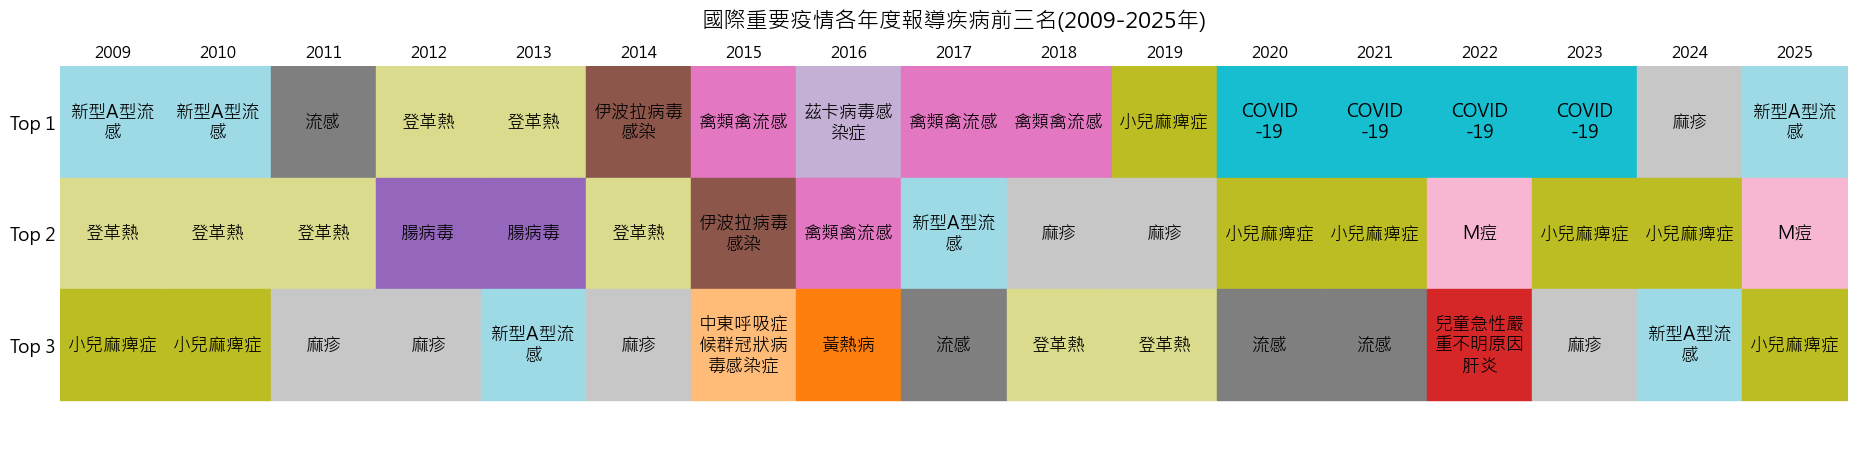

In [9]:
# --- Top-N Reported Diseases per Year (English), EXACT color alignment with proportion graph ---

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

# ========= Parameters =========
n_top_diseases = 3   # <-- set N here
wrap_width = 5      # cell label wrap width

# Build exact disease -> color mapping based on the proportion graph pairing
# Skip 'Others' for this Top-N grid (usually not part of Top-N)
plot_columns_used = list(order_zh[::-1])  # the columns you passed to df_percent[...] in the area chart

print(plot_columns_used)
print(colors_diseases_trend)
palette_map_en = {
    dis: col
    for dis, col in zip(plot_columns_used, colors_diseases_trend) # colors_diseases_trend from staked area plot
    if dis != 'Others'
}

# ========= Build Top-N table using English names =========
df_plot_en = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot_en['date'] = pd.to_datetime(df_plot_en['date'], errors='coerce')
df_plot_en['year'] = df_plot_en['date'].dt.year

df_counts_en = (
    df_plot_en
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

# Rank each year by count and keep Top-N
topN_per_year_en = (
    df_counts_en
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_diseases)
)

# Convert to per-year list for a grid, pad to N with None
ranked_en = (
    topN_per_year_en
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)

# Ensure years are sorted ascending and align data accordingly
years_en = sorted(ranked_en['year'].tolist())
ranked_en = ranked_en.set_index('year').loc[years_en].reset_index()

disease_table_en = pd.DataFrame(
    [r + [None] * (n_top_diseases - len(r)) for r in ranked_en['disease_name']],
    index=years_en
).T  # rows: Top1..TopN, cols: years


# ========= Plotting =========
fig_w = max(8, len(years_en) * 1.1)
fig_h = max(4, n_top_diseases * 1.25 + 1)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

ax.set_xlim(0, len(years_en))
ax.set_ylim(-0.5, n_top_diseases)

# Draw cells; Top 1 displayed at the top visually
for col, year in enumerate(years_en):
    for row in range(n_top_diseases):
        disease = disease_table_en.iloc[row, col]
        color = palette_map_en.get(disease, 'lightgray') if disease is not None else 'lightgray'
        y = (n_top_diseases - 1) - row  # invert so Top 1 is at top
        ax.add_patch(plt.Rectangle((col, y), 1, 1, color=color, edgecolor='black'))
        label = "\n".join(textwrap.wrap(disease, width=wrap_width)) if disease else ''
        ax.text(col + 0.5, y + 0.5, label, ha='center', va='center', fontsize=13, color='black')

# X-axis on top: years
ax.set_xticks([i + 0.5 for i in range(len(years_en))])
ax.set_xticklabels([str(y) for y in years_en], rotation=0, fontsize=11.5)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Y-axis left: Top 1..Top N
ax.set_yticks([i + 0.5 for i in range(n_top_diseases)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_diseases)][::-1], fontsize=13)

# Clean frame
for spine in ['right', 'left', 'bottom', 'top']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

# Legend: only for diseases appearing in the grid AND present in palette_map_en
appeared = pd.unique(disease_table_en.values.ravel())
appeared = [d for d in appeared if d is not None]

#Legend removed:
# legend_labels_en = [d for d in plot_columns_used if d in appeared and d in palette_map_en]  # preserves the exact plotted order
# legend_elements_en = [
#     Patch(facecolor=palette_map_en[d], edgecolor='black', label=d)
#     for d in legend_labels_en
# ]
# if legend_elements_en:
#     plt.legend(handles=legend_elements_en, bbox_to_anchor=(1.05, 1), loc='upper left',
#                title=f"Diseases (EN)")

plt.title(f"國際重要疫情各年度報導疾病前三名(2009-2025年)", fontsize=16, y=1.08)
plt.tight_layout()

plt.savefig("output/plot/heatmap_disease_top3_zh.png", dpi=300)

plt.show()

# (Optional) Debug checks to ensure alignment coverage:

missing_in_palette = [d for d in appeared if d not in palette_map_en]
if missing_in_palette:
    print("[Info] These diseases appeared in Top-N but were not in the proportion graph mapping, "
          "so they were colored 'lightgray':", missing_in_palette)


#### Combing stacked proportion with top 3 

In [13]:
from PIL import Image, ImageDraw, ImageFont

top_path = "output/plot/disease_proportion_annual_trend.png"
bottom_path = "output/plot/heatmap_disease_top3_zh.png"



# --- load
imA = Image.open(top_path).convert("RGBA")
imB = Image.open(bottom_path).convert("RGBA")

# --- make same width (keeps aspect ratio)
target_w = max(imA.width, imB.width)
def to_width(im, w):
    if im.width == w: 
        return im
    h = int(im.height * (w / im.width))
    return im.resize((w, h), Image.LANCZOS)

imA = to_width(imA, target_w)
imB = to_width(imB, target_w)

# --- compose (vertical)
margin = 24  # space around and between images (px)
out_h = imA.height + imB.height + margin * 3
canvas = Image.new("RGBA", (target_w, out_h), (255, 255, 255, 255))

y = margin
canvas.paste(imA, (0, y)); yA_top = y
y += imA.height + margin
canvas.paste(imB, (0, y)); yB_top = y

# --- annotate
draw = ImageDraw.Draw(canvas)
try:
    font = ImageFont.truetype("arial.ttf", 95)#font size
except:
    font = ImageFont.load_default()

# put the labels inside the images, near top-left
offset = 60
draw.text((offset, yA_top + offset), "(A)", fill="black",
          font=font, stroke_width=2, stroke_fill="black")
draw.text((offset, yB_top + offset), "(B)", fill="black",
          font=font, stroke_width=2, stroke_fill="black")

# --- save
canvas.convert("RGB").save("output/plot/disease_combined_AB_zh.png", dpi=(300, 300))

#### Top3 disease name heat map in eng

C:\Users\three\AppData\Local\Temp\ipykernel_30796\3672885227.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((col, y), 1, 1, color=color, edgecolor='black'))


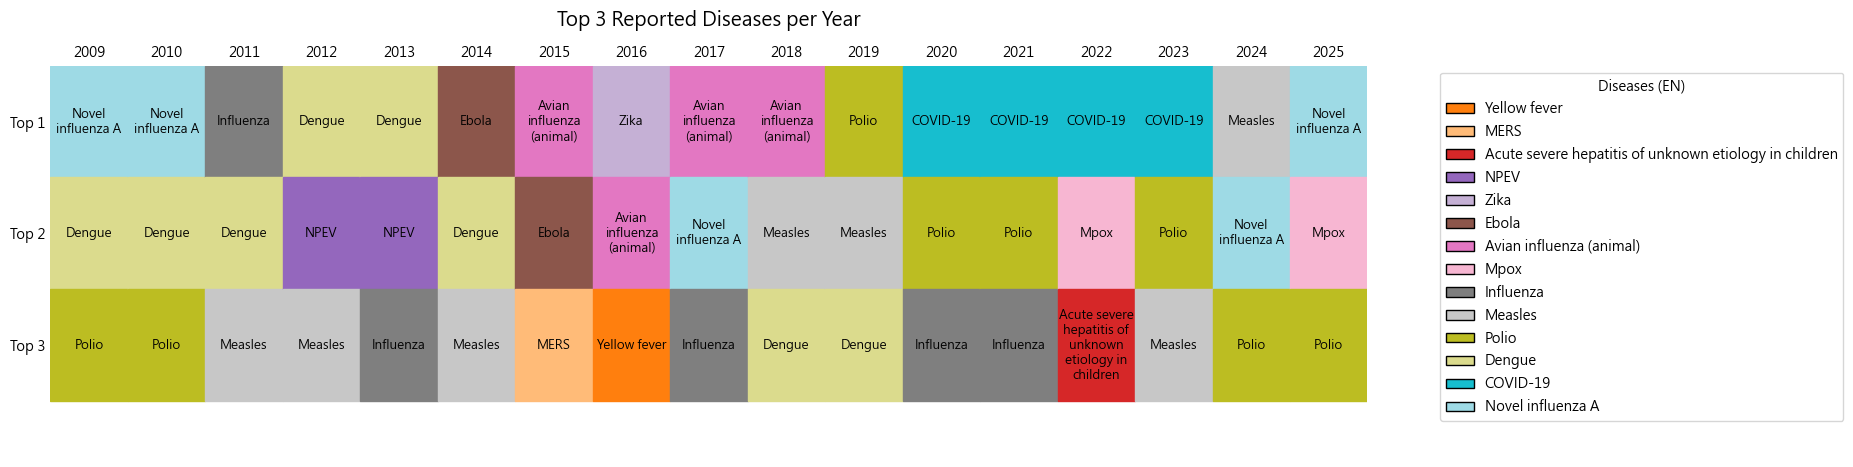

In [12]:
# --- Top-N Reported Diseases per Year (English), EXACT color alignment with proportion graph ---

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

# ========= Parameters =========
n_top_diseases = 3   # <-- set N here
wrap_width = 14      # cell label wrap width

# ========= Assumptions from your proportion graph =========
# You ALREADY have:
# - df : DataFrame with columns ['date', 'disease_name_en', ...]
# - list_common_diseases_en : Index/list of diseases to keep
# - order : disease order used in df_percent[...] for the proportion graph
# - colors_diseases_trend : color list passed to the proportion graph
#
# IMPORTANT: You said you plotted with:
#   df_percent[order[::-1]].plot(..., color=colors_diseases_trend)
# So we must build the mapping using that SAME pairing:

# Build exact disease -> color mapping based on the proportion graph pairing
# Skip 'Others' for this Top-N grid (usually not part of Top-N)
plot_columns_used = list(order[::-1])  # the columns you passed to df_percent[...] in the area chart
palette_map_en = {
    dis: col
    for dis, col in zip(plot_columns_used, colors_diseases_trend)
    if dis != 'Others'
}

# ========= Build Top-N table using English names =========
df_plot_en = df[df['disease_name_en'].isin(list_common_diseases_en)].copy()
df_plot_en['date'] = pd.to_datetime(df_plot_en['date'], errors='coerce')
df_plot_en['year'] = df_plot_en['date'].dt.year

df_counts_en = (
    df_plot_en
    .groupby(['year', 'disease_name_en'])
    .size()
    .reset_index(name='count')
)

# Rank each year by count and keep Top-N
topN_per_year_en = (
    df_counts_en
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_diseases)
)

# Convert to per-year list for a grid, pad to N with None
ranked_en = (
    topN_per_year_en
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name_en']
    .apply(list)
    .reset_index()
)

# Ensure years are sorted ascending and align data accordingly
years_en = sorted(ranked_en['year'].tolist())
ranked_en = ranked_en.set_index('year').loc[years_en].reset_index()

disease_table_en = pd.DataFrame(
    [r + [None] * (n_top_diseases - len(r)) for r in ranked_en['disease_name_en']],
    index=years_en
).T  # rows: Top1..TopN, cols: years

# ========= Plotting =========
fig_w = max(8, len(years_en) * 1.1)
fig_h = max(4, n_top_diseases * 1.25 + 1)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

ax.set_xlim(0, len(years_en))
ax.set_ylim(-0.5, n_top_diseases)

# Draw cells; Top 1 displayed at the top visually
for col, year in enumerate(years_en):
    for row in range(n_top_diseases):
        disease = disease_table_en.iloc[row, col]
        color = palette_map_en.get(disease, 'lightgray') if disease is not None else 'lightgray'
        y = (n_top_diseases - 1) - row  # invert so Top 1 is at top
        ax.add_patch(plt.Rectangle((col, y), 1, 1, color=color, edgecolor='black'))
        label = "\n".join(textwrap.wrap(disease, width=wrap_width)) if disease else ''
        ax.text(col + 0.5, y + 0.5, label, ha='center', va='center', fontsize=9, color='black')

# X-axis on top: years
ax.set_xticks([i + 0.5 for i in range(len(years_en))])
ax.set_xticklabels([str(y) for y in years_en], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Y-axis left: Top 1..Top N
ax.set_yticks([i + 0.5 for i in range(n_top_diseases)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_diseases)][::-1], fontsize=10)

# Clean frame
for spine in ['right', 'left', 'bottom', 'top']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

# Legend: only for diseases appearing in the grid AND present in palette_map_en
appeared = pd.unique(disease_table_en.values.ravel())
appeared = [d for d in appeared if d is not None]
legend_labels_en = [d for d in plot_columns_used if d in appeared and d in palette_map_en]  # preserves the exact plotted order

legend_elements_en = [
    Patch(facecolor=palette_map_en[d], edgecolor='black', label=d)
    for d in legend_labels_en
]
if legend_elements_en:
    plt.legend(handles=legend_elements_en, bbox_to_anchor=(1.05, 1), loc='upper left',
               title=f"Diseases (EN)")

plt.title(f"Top {n_top_diseases} Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

# (Optional) Debug checks to ensure alignment coverage:
missing_in_palette = [d for d in appeared if d not in palette_map_en]
if missing_in_palette:
    print("[Info] These diseases appeared in Top-N but were not in the proportion graph mapping, "
          "so they were colored 'lightgray':", missing_in_palette)



### Report histogram

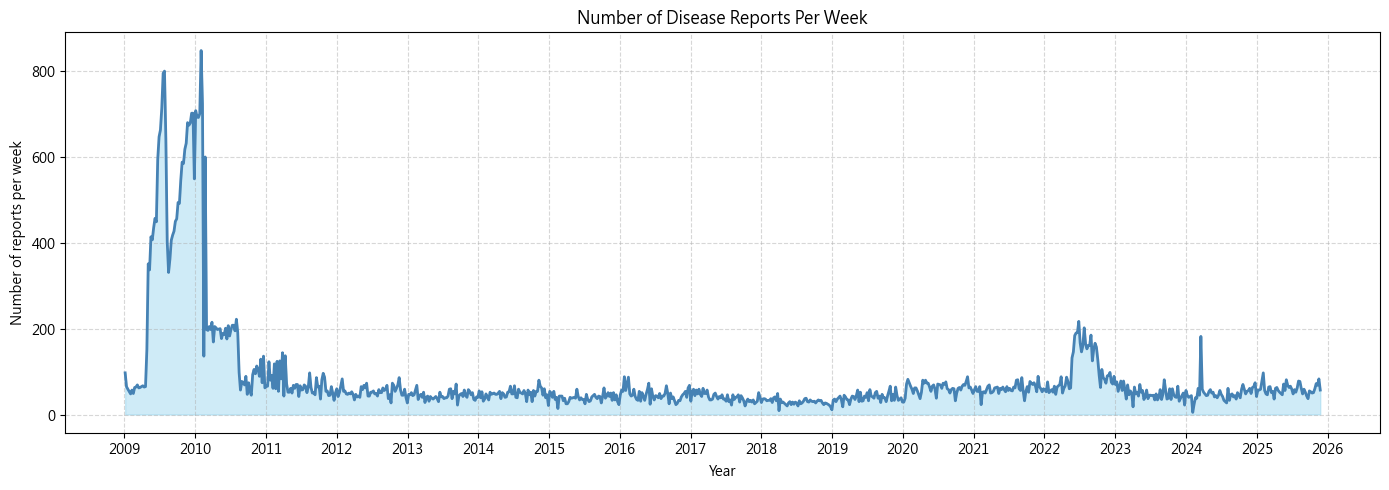

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 🟢 Step 1: Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# 🟢 Step 2: Create a new 'week' column that represents the start of each week
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 3: Group by week and count number of reports per week
df_weekly_counts = df.groupby('week').size().reset_index(name='count')

# 🟢 Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bubble plot by disease

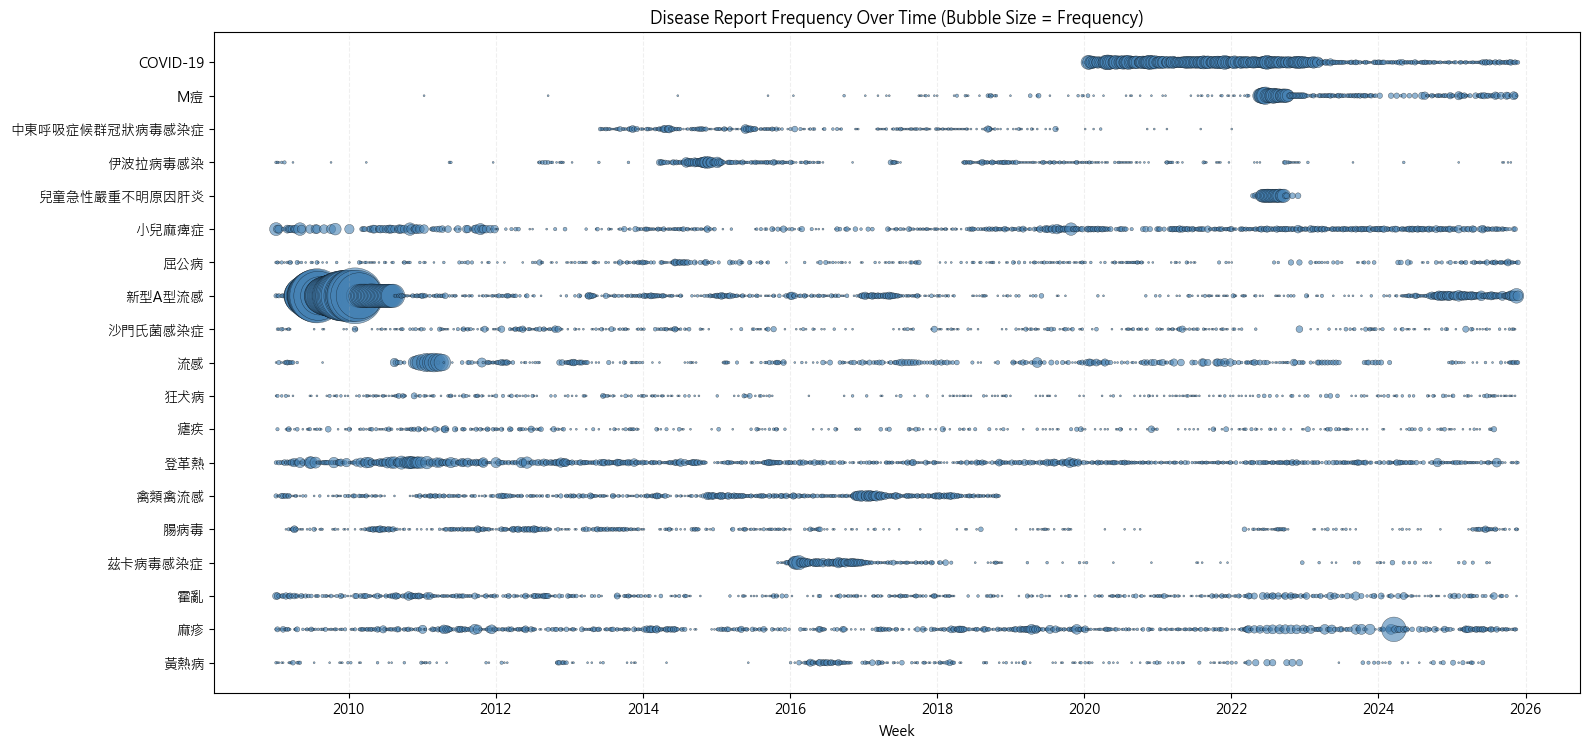

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 🟢 Step 1: Prepare data
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(16, len(disease_list) * 0.4))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show() 


### Bubble plot for PHEIC diseases

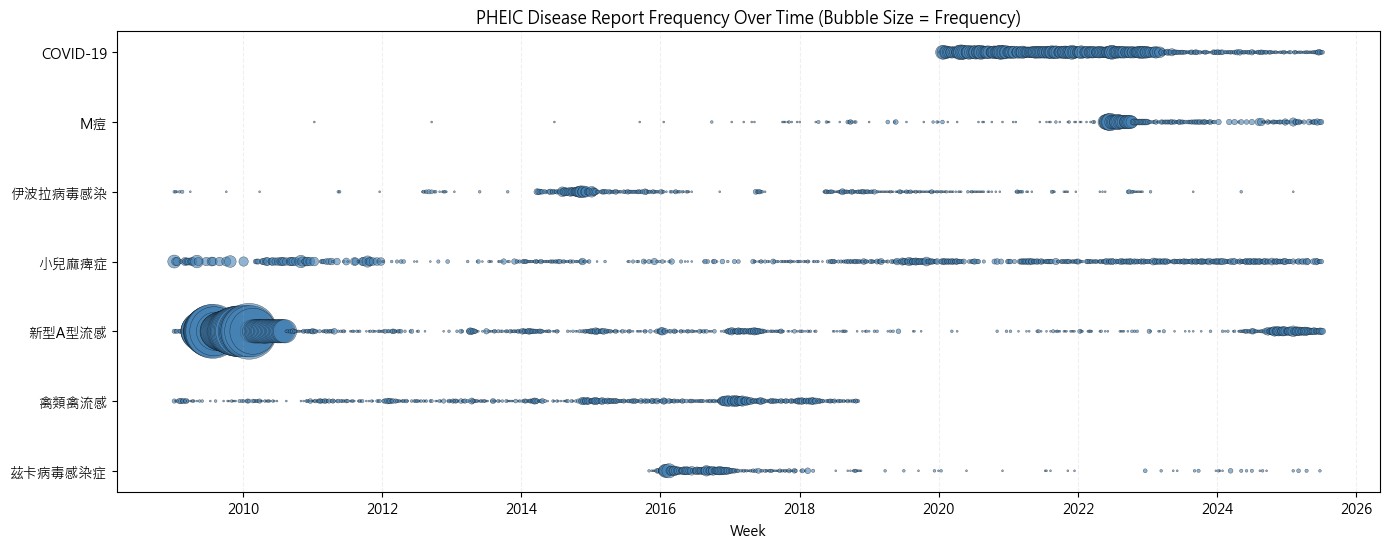

In [18]:
# only PHEIC diseases
import pandas as pd
import matplotlib.pyplot as plt


list_PHEIC_diseases = ["COVID-19","新型A型流感","禽類禽流感","小兒麻痺症","伊波拉病毒感染","M痘","茲卡病毒感染症"]


df_plot = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(14, len(disease_list) * 0.8))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("PHEIC Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


## transmission routes


<Figure size 1200x600 with 0 Axes>

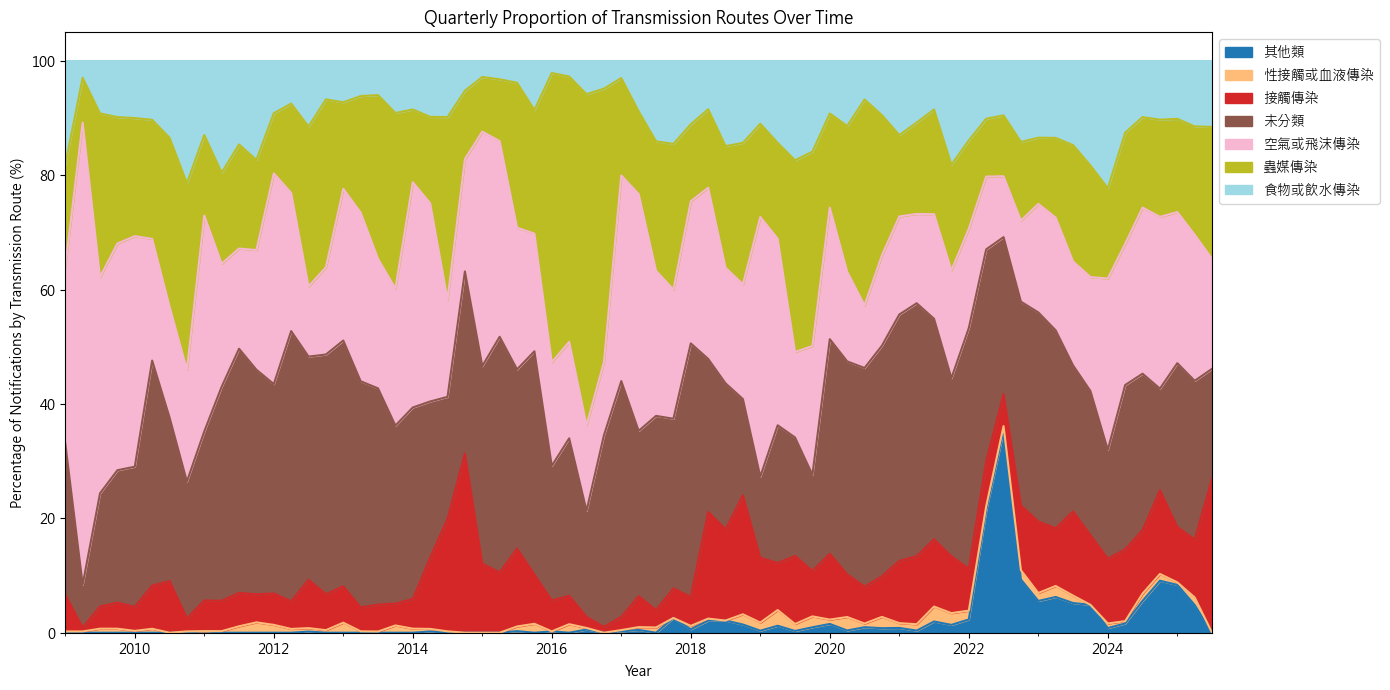

In [19]:
import matplotlib.pyplot as plt
import matplotlib

# 🧾 Font settings for Traditional Chinese
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# 🟢 Step 1: Prepare copy and fill NaNs
df_plot = df_raw.copy()
df_plot['transmission_route'] = df_plot['transmission_route'].fillna('未分類')

# 🟢 Step 2: Extract quarter and group counts by quarter + transmission route
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')

df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'transmission_route'])  # quarterly
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Convert period to timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# 🟢 Step 4: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='transmission_route', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# 🟢 Step 5: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Notifications by Transmission Route (%)')
plt.title('Quarterly Proportion of Transmission Routes Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Country visualisations

### Top ten countries

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_13816\2206951059.py:55: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



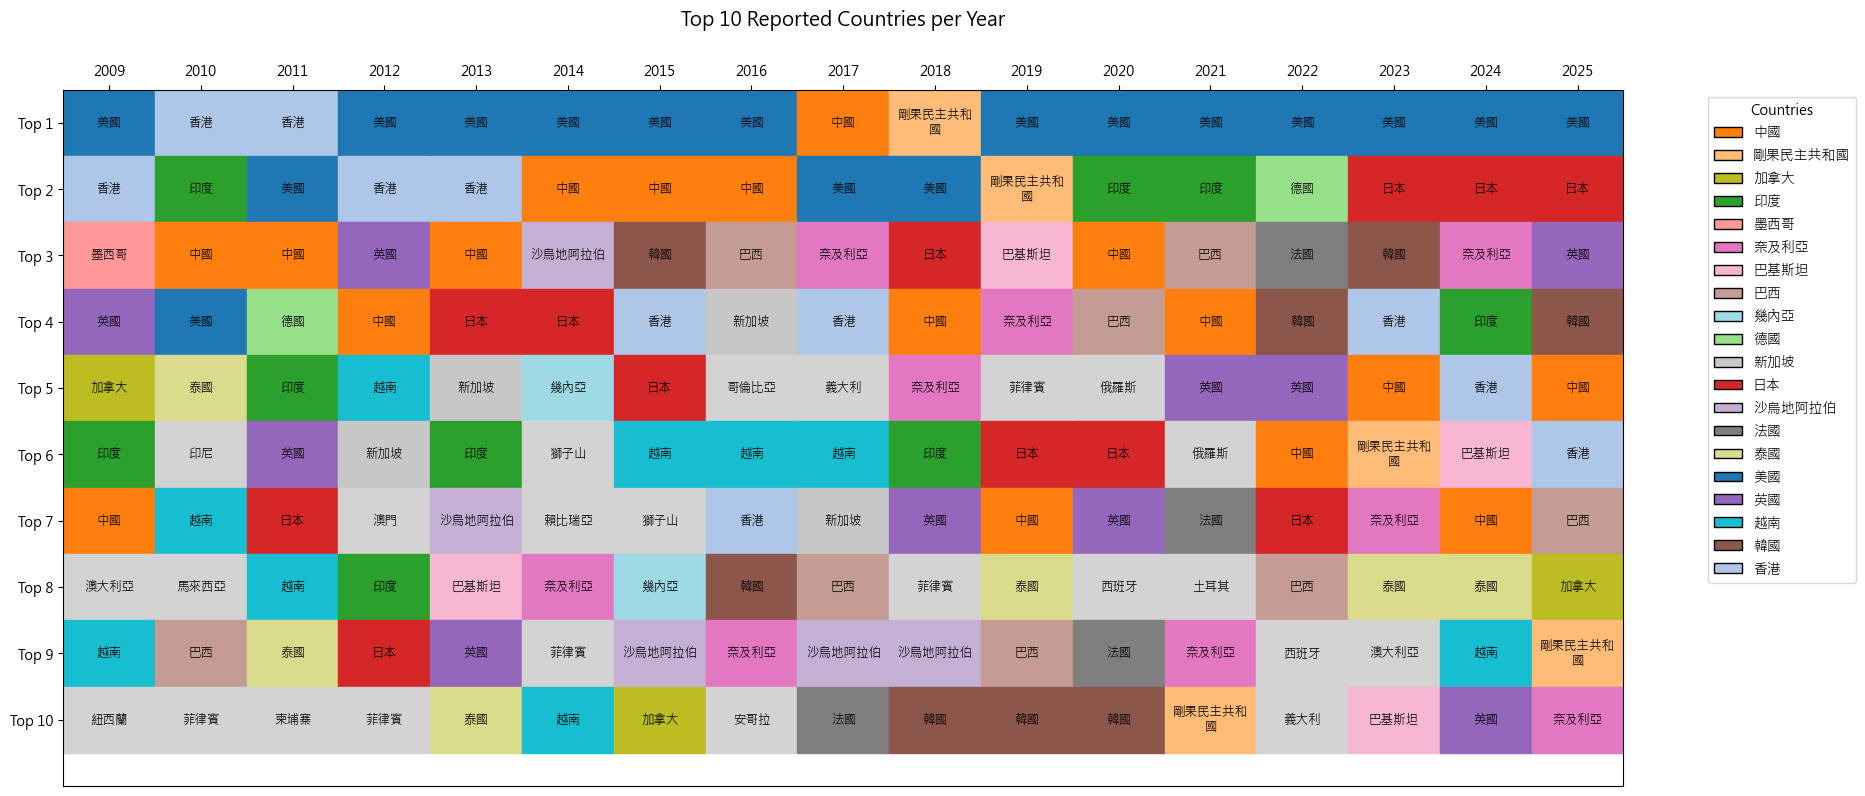

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

n_top_countries = 10

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

df_counts = (
    df_plot
    .groupby(['year', 'country_name_zh'])
    .size()
    .reset_index(name='count')
)

top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# 🟢 Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_name_zh']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_name_zh']],
    index=years
).T

# 🟢 Assign unique colors
all_countries = pd.unique(country_table.values.ravel())
color_map = dict(zip(all_countries, plt.cm.tab20.colors[:len(all_countries)]))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country = country_table.iloc[row, col]
        color = color_map.get(country, 'lightgray')
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country, width=6)) if country else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in sorted(color_map) if c is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Countries")

plt.title(f"Top {n_top_countries} Reported Countries per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

In [21]:
### Top regions

### Top N country_disease

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_13816\821595555.py:74: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



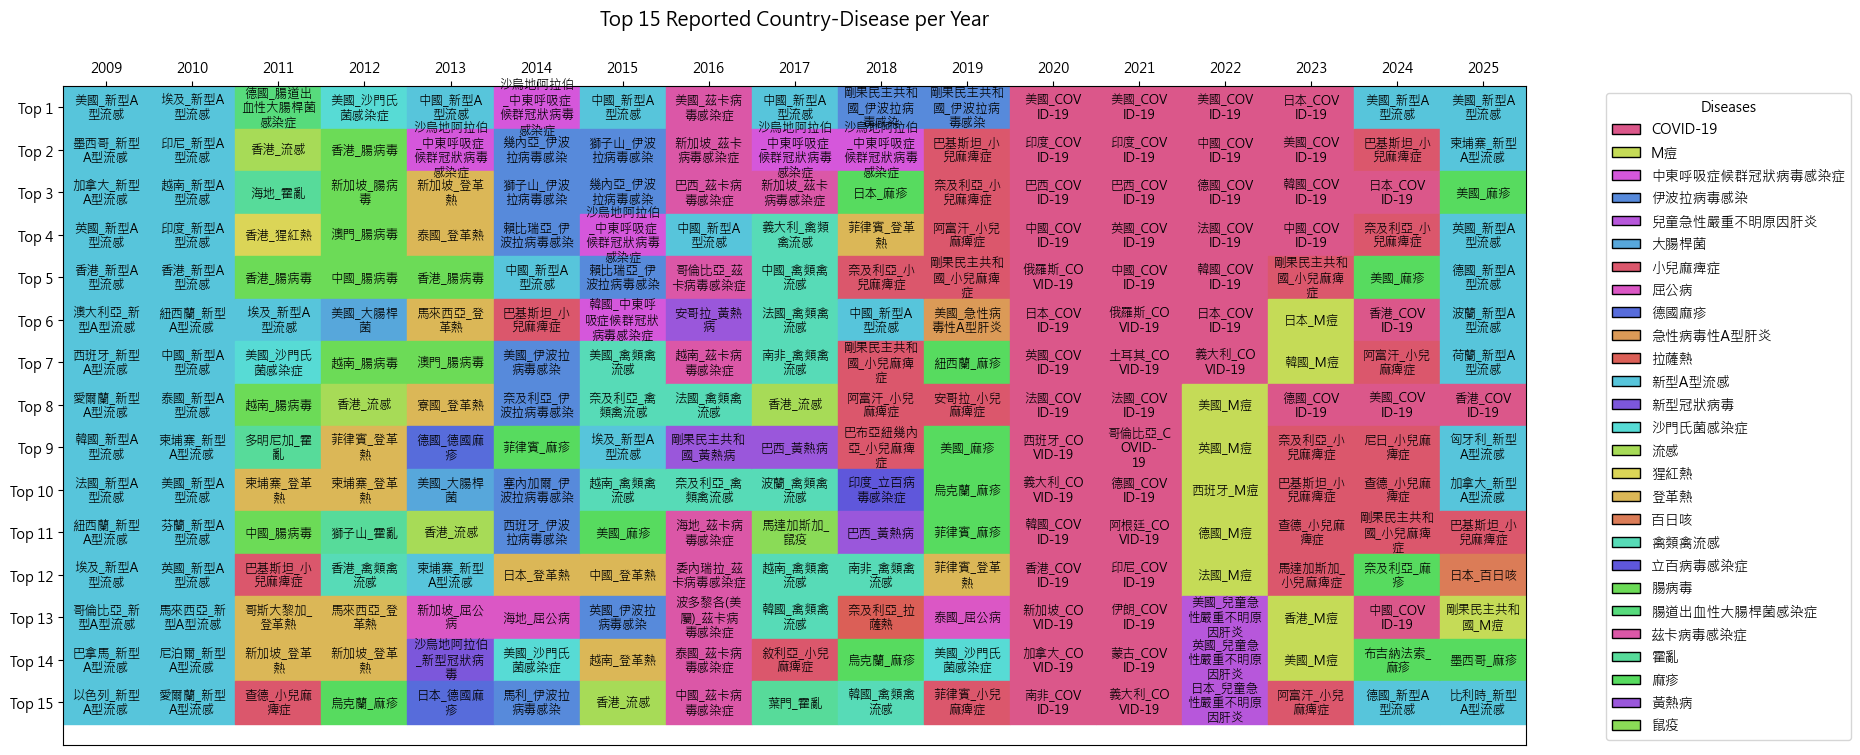

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import textwrap

# 🟢 Parameters
n_top_countries = 15

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

# Group by year and country_disease, count occurrences
df_counts = (
    df_plot
    .groupby(['year', 'country_disease'])
    .size()
    .reset_index(name='count')
)

# Get top N per year
top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_disease']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_disease']],
    index=years
).T

# 🟢 Extract unique disease names from country_disease strings in top N
diseases_in_top = set()
for col in country_table.columns:
    for val in country_table[col]:
        if val:
            disease = val.split('_')[-1]
            diseases_in_top.add(disease)

# Generate color palette for these diseases
palette = sns.color_palette("hls", len(diseases_in_top))
disease_color_map = dict(zip(diseases_in_top, palette))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country_disease = country_table.iloc[row, col]
        
        if country_disease:
            # Extract disease_name from country_disease (split by "_")
            disease = country_disease.split('_')[-1]
            color = disease_color_map.get(disease, 'lightgray')
        else:
            color = 'lightgray'
        
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country_disease, width=6)) if country_disease else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# 🟢 Legend showing only disease names
legend_elements = [
    Patch(facecolor=disease_color_map[d], edgecolor='black', label=d)
    for d in sorted(diseases_in_top) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title(f"Top {n_top_countries} Reported Country-Disease per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()


# Variety

### 1. Diversity count (baseline)

In [23]:
variety_count = df.groupby(df['date'].dt.year)['country_disease'].nunique().reset_index()
variety_count.columns = ['year', 'unique_country_disease_count']
print(variety_count)


    year  unique_country_disease_count
0   2009                           787
1   2010                          1015
2   2011                          1085
3   2012                           907
4   2013                           714
5   2014                           626
6   2015                           640
7   2016                           630
8   2017                           591
9   2018                           475
10  2019                           603
11  2020                           549
12  2021                           573
13  2022                           729
14  2023                           760
15  2024                           784
16  2025                           511


## 2. Entropy

COUNTRY-DISEASE

    year  shannon_entropy
0   2009             5.34
1   2010             5.82
2   2011             6.40
3   2012             6.20
4   2013             5.88
5   2014             5.39
6   2015             5.69
7   2016             5.61
8   2017             5.50
9   2018             5.48
10  2019             5.70
11  2020             4.94
12  2021             4.99
13  2022             5.16
14  2023             5.98
15  2024             6.11
16  2025             5.74


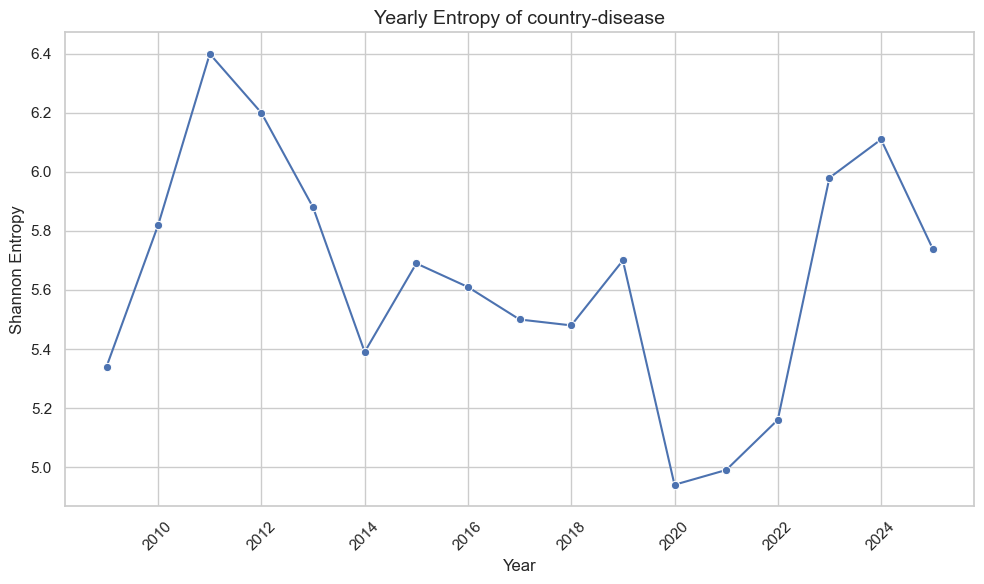

In [24]:
import numpy as np

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

table_entropy = df.groupby(df['date'].dt.year)['country_disease'].apply(shannon_entropy).reset_index().round(2)
table_entropy.columns = ['year', 'shannon_entropy']
print(table_entropy)


import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=table_entropy, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of country-disease', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

DISEASE only entropy

    year  shannon_entropy
0   2009             0.62
1   2010             1.41
2   2011             3.30
3   2012             3.74
4   2013             3.81
5   2014             3.17
6   2015             3.45
7   2016             2.70
8   2017             3.12
9   2018             3.33
10  2019             3.22
11  2020             1.92
12  2021             2.11
13  2022             2.38
14  2023             3.29
15  2024             3.32
16  2025             3.04


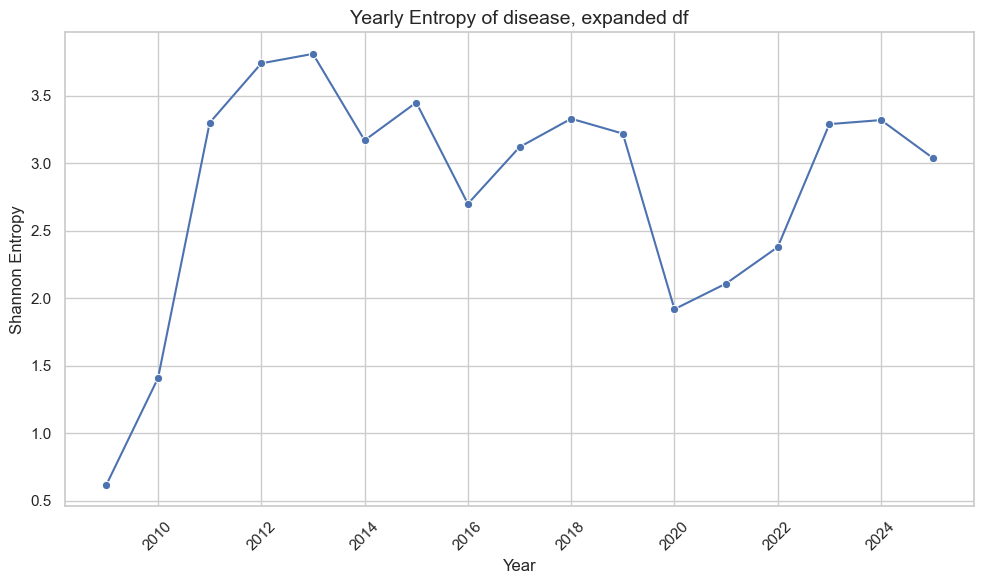

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

table_entropy_disease = df.groupby(df['date'].dt.year)['disease_name'].apply(shannon_entropy).reset_index().round(2)
table_entropy_disease.columns = ['year', 'shannon_entropy']
print(table_entropy_disease)

sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=table_entropy_disease, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of disease, expanded df', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [8]:
print(df_raw.head())

NameError: name 'df_raw' is not defined

# Timeliness

### Prepare dataset (not conslolidated one "df")
- use df_raw instead of df, which has been expanded by disease and country
- extract end date from description, and get a adjusted source date from SourceTime, SourceTime2, SourceTime_description.
- calculate interval between source date and publish
- calculate median value by year and assess missingness

In [27]:
# (1) extract date from source ###
def extract_source_time_source(row):
    source = row['Source']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = date_row.year if pd.notna(date_row) else None

    if pd.isna(source) or year is None:
        return pd.NaT

    # Regex to find dates like "9/20" or "8/2"
    matches = re.findall(r'(\d{1,2})/(\d{1,2})', source)
    
    most_recent_date = pd.NaT

    for month_str, day_str in matches:
        month = int(month_str)
        day = int(day_str)
        try:
            date_obj = pd.Timestamp(year=year, month=month, day=day)
            
            # Skip if date_obj is after the reference date
            if date_obj > date_row:
                continue

            # Update if more recent
            if pd.isna(most_recent_date) or date_obj > most_recent_date:
                most_recent_date = date_obj

        except ValueError:
            continue  # Skip invalid dates

    return most_recent_date


df_raw['SourceTime_source'] = df_raw.apply(extract_source_time_source, axis=1)


# (2) extract the source date from the description ### 
def extract_source_time(row):
    # Only extract if both SourceTime and SourceTime2 are missing
    if pd.notna(row['SourceTime']) or pd.notna(row['SourceTime2']):
        return pd.NaT

    description = row['description']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = pd.to_datetime(row['date'], errors='coerce').year

    if pd.isna(description):
        return pd.NaT

    # Find all patterns like "截至今年12/8" or "截至12/8" or "今年截至12/8" or "截至6月25日" or "截至今年6月25日"
    matches = re.findall(r'截至(?:今年)?(\d{1,2})[月/](\d{1,2})日?', description)
    
    if matches:
        dates = []
        for month_str, day_str in matches:
            month = int(month_str)
            day = int(day_str)
            try:
                date_obj = pd.Timestamp(year=year, month=month, day=day)
                dates.append(date_obj)
            except ValueError:
                continue  # skip invalid dates

        if dates:
            max_date = max(dates)
            if max_date > date_row:  # If max_date is later than date_row, treat as missing
                return pd.NaT
            else:
                return max_date    
    return pd.NaT

df_raw['SourceTime_description'] = df_raw.apply(extract_source_time, axis=1)

# (3) Get adjusted source date ###
def calculate_adjusted_source_time(row):
    t1 = row['SourceTime']
    t2 = row['SourceTime2']
    t3 = row['SourceTime_description'] 
    t4 = row['SourceTime_source']
    if pd.notna(t1) and pd.notna(t2):
        # initially I tried to look the median of t1 t2, which looks bad in 2020-2024, so now I only choose the most recent source date
        # delta_days = (t2 - t1).days
        # half_days_ceil = int(np.ceil(delta_days / 2)) #round up to an integer number of days (無條件進位)
        # return t1 + pd.Timedelta(days=half_days_ceil)
        return t2
    elif pd.notna(t2):
        return t2
    elif pd.notna(t1):
        return t1
    elif pd.notna(t3):
        return t3
    elif pd.notna(t4):
        return t4
    else:
        return pd.NaT # Both missing

df_raw['SourceTime_adj'] = df_raw.apply(calculate_adjusted_source_time, axis=1)

# (4) calculate interval between publish date and median source date ###
def calculate_interval_source_publish(row):
    date_source = pd.to_datetime(row['SourceTime_adj'], errors='coerce')
    date_publish = pd.to_datetime(row['date'], errors='coerce')
    if pd.notna(date_source) and pd.notna(date_publish):
        delta_days = (date_publish - date_source).days
        return delta_days
    else:
        return pd.NaT 

df_raw['interval_source_publish'] = df_raw.apply(calculate_interval_source_publish, axis=1)
df_raw['year'] = pd.to_datetime(df_raw['date']).dt.year

# (5) Group by year and aggregate ###
table_timeliness_byyear = (
    df_raw.groupby('year')
    .agg(
        median_interval=('interval_source_publish', 'median'),
        mean_interval=('interval_source_publish', 'mean'),
        missing_percent=('SourceTime_adj', lambda x: x.isna().mean().round(3) * 100) )# equals to "interval_source_publish"
    .reset_index())

print(table_timeliness_byyear)

# df_raw_source_date_missing = df_raw[df_raw['interval_source_publish'].isna()]
# df_raw_source_date_missing.to_csv('interval_source_publish_missing.csv', index=True)

    year median_interval mean_interval  missing_percent
0   2009             5.0      7.478788             91.3
1   2010             6.0      7.548023             78.4
2   2011             6.0      8.607143             83.7
3   2012             8.0     11.935211             80.7
4   2013             8.0     12.485816             84.4
5   2014             5.0      6.340611             86.5
6   2015             6.0      9.641694             78.8
7   2016             8.0     11.040268             81.1
8   2017             7.0     10.428571             79.2
9   2018             7.0          11.8             75.4
10  2019             7.0      9.861298             64.3
11  2020             3.0       7.14311             47.6
12  2021             4.0      7.969799             46.1
13  2022             1.0      5.350068             34.8
14  2023             7.0      9.714597             49.1
15  2024            10.0         12.72             64.3
16  2025             7.0      9.867257          

### Plot the median of interval source-publish

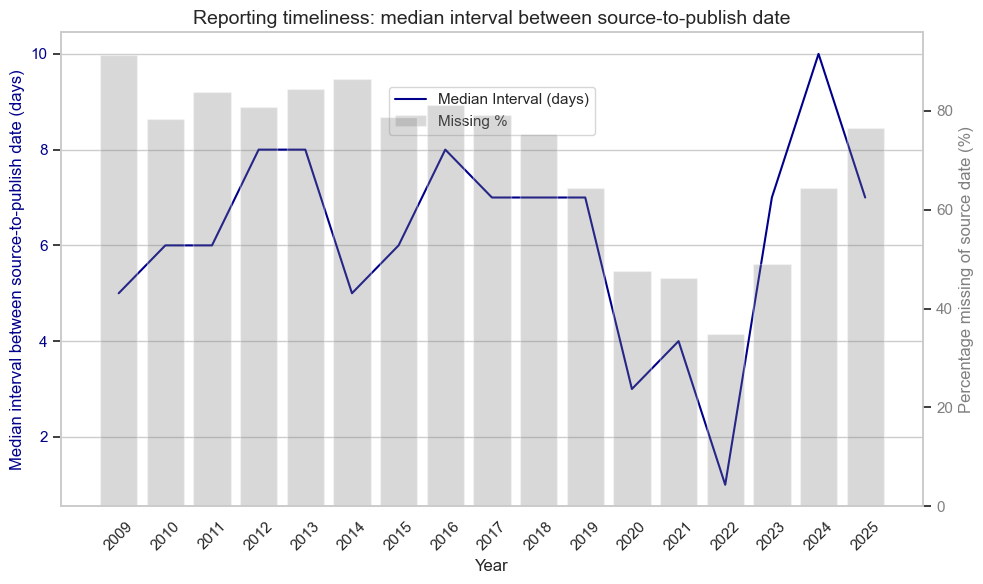

In [28]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot median interval (line) on left y-axis
ax1.plot(table_timeliness_byyear['year'], table_timeliness_byyear['median_interval'],
         color='darkblue', label='Median Interval (days)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median interval between source-to-publish date (days)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Set x-axis to integer years
ax1.set_xticks(table_timeliness_byyear['year'])
ax1.set_xticklabels(table_timeliness_byyear['year'].astype(int), rotation=45)
ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', visible=True)

# Create right y-axis for missing percentage
ax2 = ax1.twinx()
ax2.bar(table_timeliness_byyear['year'], table_timeliness_byyear['missing_percent'],
        alpha=0.3, color='grey', label='Missing %')
ax2.set_ylabel('Percentage missing of source date (%)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.grid(axis='y', visible=False)

# 🔧 Titles and layout
plt.title('Reporting timeliness: median interval between source-to-publish date', fontsize=14)
fig.tight_layout()

# 🔧 Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 0.9))

plt.show()

# Sanky plot: data sources, country, disease, transmission routs

In [29]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# Step 1: Prepare data
df['date'] = pd.to_datetime(df['date'])

df_temp = df[df['date'].dt.year > 2020]# subsetting 2009, 2020

df_temp = df_temp[['country_name_zh', 'disease_name']]


# Step 2: Keep top 5 countries and diseases, group others
top_countries = df_temp['country_name_zh'].value_counts().nlargest(10).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(10).index
print(top_countries)
df_temp['country_name_zh_sanky'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), '其他國家')
df_temp['disease_name_sanky'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), '其他疾病')

# Step 3: Group and filter
df_grouped = df_temp.groupby(['country_name_zh_sanky', 'disease_name_sanky']).size().reset_index(name='count')
df_grouped = df_grouped[df_grouped['count'] >= 100]# to make the graph less busy

# Step 4: Build node list and index
all_nodes = pd.Series(df_grouped['country_name_zh_sanky'].tolist() + df_grouped['disease_name_sanky'].tolist()).unique()
node_indices = {name: i for i, name in enumerate(all_nodes)}
df_grouped['source'] = df_grouped['country_name_zh_sanky'].map(node_indices)
df_grouped['target'] = df_grouped['disease_name_sanky'].map(node_indices)

# Step 5: Assign reasonable node colors
# Use pastel Set3 for visual harmony (enough contrast, easy on eyes)
# color_palette = pc.qualitative.Set3
# node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]
color_palette = pc.qualitative.Bold  # High-contrast, vivid
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]


# Step 6: Assign link colors based on target (disease node)
target_colors = {name: node_colors[node_indices[name]] for name in df_grouped['disease_name_sanky'].unique()}
df_grouped['link_color'] = df_grouped['disease_name_sanky'].map(target_colors)

# Step 7: Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_grouped['source'],
        target=df_grouped['target'],
        value=df_grouped['count'],
        color=df_grouped['link_color']  # match disease color
    )
)])

fig.update_layout(
    width=800,
    height=900,
    title_text="Sankey Diagram: Countries to Diseases, 2020-2025",
    font_size=12
)
fig.show()




Index(['美國', '中國', '日本', '巴西', '英國', '韓國', '德國', '法國', '印度', '奈及利亞'], dtype='object', name='country_name_zh')


### Sanky: region-country-disease-route

In [30]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# === Step 1: Prepare and clean data ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_temp = df[df['date'].dt.year > 2020][['WHO_region', 'country_name_zh', 'disease_name', 'transmission_route']]

# === Step 2: Keep top N countries and diseases for clarity ===
top_countries = df_temp['country_name_zh'].value_counts().nlargest(15).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(15).index


df_temp['country_grouped'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), '其它國家')
df_temp['disease_grouped'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), '其它疾病')
df_temp['route_grouped'] = df_temp['transmission_route'].fillna('Unknown')
df_temp['region_grouped'] = df_temp['WHO_region'].fillna('Other')

# === Step 3: Create three sets of links ===
link0 = (
    df_temp.groupby(['region_grouped', 'country_grouped'])
    .size()
    .reset_index(name='count')
)

link1 = (
    df_temp.groupby(['country_grouped', 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

link2 = (
    df_temp.groupby(['disease_grouped', 'route_grouped'])
    .size()
    .reset_index(name='count')
)

# === Step 4: Filter small links to reduce clutter ===
link0 = link0[link0['count'] >= 50]
link1 = link1[link1['count'] >= 50]
link2 = link2[link2['count'] >= 50]

# === Step 5: Build unique node list and index mapping ===
all_nodes = pd.Series(
    link0['region_grouped'].tolist() +
    link0['country_grouped'].tolist() +
    link1['disease_grouped'].tolist() +
    link2['route_grouped'].tolist()
).unique()

node_indices = {name: i for i, name in enumerate(all_nodes)}

# Map source and target indices
link0['source'] = link0['region_grouped'].map(node_indices)
link0['target'] = link0['country_grouped'].map(node_indices)

link1['source'] = link1['country_grouped'].map(node_indices)
link1['target'] = link1['disease_grouped'].map(node_indices)

link2['source'] = link2['disease_grouped'].map(node_indices)
link2['target'] = link2['route_grouped'].map(node_indices)

# === Step 6: Assign colors to nodes ===
color_palette = pc.qualitative.Bold
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]

# Color by disease and route for links
disease_color_map = {name: node_colors[node_indices[name]] for name in link1['disease_grouped'].unique()}
route_color_map = {name: node_colors[node_indices[name]] for name in link2['route_grouped'].unique()}

link0['color'] = link0['country_grouped'].map(lambda x: node_colors[node_indices.get(x, 0)])
link1['color'] = link1['disease_grouped'].map(disease_color_map)
link2['color'] = link2['route_grouped'].map(route_color_map)

# === Step 7: Combine all links ===
df_links = pd.concat([
    link0[['source', 'target', 'count', 'color']],
    link1[['source', 'target', 'count', 'color']],
    link2[['source', 'target', 'count', 'color']]
], ignore_index=True)

# === Step 8: Plot Sankey Diagram ===
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_links['source'],
        target=df_links['target'],
        value=df_links['count'],
        color=df_links['color']
    )
)])


fig.update_layout(
    font=dict(size=14, color='black', family="Arial"),
    title_text="Sankey Diagram: WHO Region → Country → Disease → Transmission Route (2021–2025)",
    width=1100,
    height=950
)

fig.write_image("output/plot/Sankey_region_country_disease_route_2021_2025.png", width=1100, height=950, scale=3)
fig.show()



In [29]:
# text report
print(top_countries)
print(top_diseases)


WHO_region_counts = df_temp['WHO_region'].value_counts()
WHO_region_proportions = df_temp['WHO_region'].value_counts(normalize=True)

df_region_summary = pd.DataFrame({
    'count': WHO_region_counts,
    'proportion (%)': (WHO_region_proportions * 100).round(2)
})

print(df_region_summary)

Index(['美國', '中國', '日本', '巴西', '英國', '韓國', '德國', '法國', '印度', '奈及利亞', '剛果民主共和國',
       '西班牙', '香港', '加拿大', '義大利'],
      dtype='object', name='country_name_zh')
Index(['COVID-19', 'M痘', '小兒麻痺症', '麻疹', '兒童急性嚴重不明原因肝炎', '新型A型流感', '登革熱', '霍亂',
       '流感', '黃熱病', '沙門氏菌感染症', '屈公病', '百日咳', '拉薩熱', '克里米亞-剛果出血熱'],
      dtype='object', name='disease_name')
            count  proportion (%)
WHO_region                       
歐洲           3627           23.89
西太平洋         3575           23.55
美洲           3351           22.07
非洲           2907           19.15
東地中海          867            5.71
東南亞           831            5.47
其它             24            0.16


### Sanky: region-country-disease in Man

In [30]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc
import numpy as np

# -----------------------------
# Params
# -----------------------------
YEAR_MIN = 2021            # >2020
TOP_COUNTRIES = 15
TOP_DISEASES  = 15
COUNT_MIN     = 50         # filter tiny links
OTHER_COUNTRY_LABEL = "其它國家"
OTHER_DISEASE_LABEL = "其它疾病"
OTHER_REGION_LABEL  = "其它"


# -----------------------------
# Step 1: Prepare / clean data
df_work = df.copy()
df_work['date'] = pd.to_datetime(df_work['date'], errors='coerce')

needed_cols = ['WHO_region', 'country_name_zh', 'disease_name']
missing = [c for c in needed_cols if c not in df_work.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please create them first.")

# Keep rows since YEAR_MIN
df_temp = df_work.loc[df_work['date'].dt.year > (YEAR_MIN - 1),
                      ['WHO_region', 'country_name_zh', 'disease_name']].copy()


# Some pipelines keep lists (e.g., multi-disease headlines). Explode if needed.
for col in ['country_name_zh', 'disease_name']:
    if df_temp[col].apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).any():
        df_temp = df_temp.explode(col).reset_index(drop=True)

# Fill missing
df_temp['WHO_region']  = df_temp['WHO_region'].fillna(OTHER_REGION_LABEL)
df_temp['country_name_zh'] = df_temp['country_name_zh'].fillna(OTHER_COUNTRY_LABEL)
df_temp['disease_name'] = df_temp['disease_name'].fillna('Unknown')

# Step 2: Top-N filtering
top_countries = df_temp['country_name_zh'].value_counts().nlargest(TOP_COUNTRIES).index
top_diseases  = df_temp['disease_name'].value_counts().nlargest(TOP_DISEASES).index

df_temp['country_grouped'] = df_temp['country_name_zh'].where(
    df_temp['country_name_zh'].isin(top_countries),
    OTHER_COUNTRY_LABEL
)
df_temp['disease_grouped'] = df_temp['disease_name'].where(
    df_temp['disease_name'].isin(top_diseases),
    OTHER_DISEASE_LABEL
)
df_temp['region_grouped']  = df_temp['WHO_region'].fillna(OTHER_REGION_LABEL)

# Step 3: Build links (Region→Country, Country→Disease)
link0 = (
    df_temp.groupby(['region_grouped', 'country_grouped'])
           .size().reset_index(name='count')
)
link1 = (
    df_temp.groupby(['country_grouped', 'disease_grouped'])
           .size().reset_index(name='count')
)

# Filter out small links to reduce clutter
link0 = link0[link0['count'] >= COUNT_MIN]
link1 = link1[link1['count'] >= COUNT_MIN]

# Step 4: Build node list & indices
#   Order nodes by tier so colors are consistent and layout is readable.
regions  = link0['region_grouped'].unique().tolist()
countries = pd.unique(link0['country_grouped'].tolist() + link1['country_grouped'].tolist()).tolist()
diseases = link1['disease_grouped'].unique().tolist()

all_nodes = regions + countries + diseases
node_indices = {name: i for i, name in enumerate(all_nodes)}

# Map source/target indices
link0 = link0.assign(
    source = link0['region_grouped'].map(node_indices),
    target = link0['country_grouped'].map(node_indices)
)
link1 = link1.assign(
    source = link1['country_grouped'].map(node_indices),
    target = link1['disease_grouped'].map(node_indices)
)


# Step 5: Colors
#   One palette applied across nodes; links colored by their target tier category
#   (region→country uses country color; country→disease uses disease color).
palette = pc.qualitative.Bold  # or Set3 / Dark24 etc.
node_colors = [palette[i % len(palette)] for i in range(len(all_nodes))]

country_color_map = {name: node_colors[node_indices[name]] for name in countries}
disease_color_map = {name: node_colors[node_indices[name]] for name in diseases}

link0['color'] = link0['country_grouped'].map(country_color_map)
link1['color'] = link1['disease_grouped'].map(disease_color_map)

# Combine links
df_links = pd.concat([
    link0[['source', 'target', 'count', 'color']],
    link1[['source', 'target', 'count', 'color']]
], ignore_index=True)


# Step 6: Plot Sankey (3-level)
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_links['source'],
        target=df_links['target'],
        value=df_links['count'],
        color=df_links['color']
    )
)])

fig.update_layout(font=dict(size=20))#title_font=dict(size=22)

fig.update_layout(
    font=dict(size=18.5, color='black', family="Arial"),
    #title_text="國際重要疫情依WHO區署、國家、疾病流量分布圖(2021–2025年)",
     title=dict(
        text=(
            "國際重要疫情依WHO區署、國家、疾病流量分布圖(2021–2025年)"
            "<br><span style='font-size:14px;color:#555'>國家疾病小於50則者省略不繪出</span>"
        ),
        x=0.5, xanchor="center", y=0.95, yanchor="top"
    ),
    
    width=1100,
    height=800
)

# fig.write_image("output/plot/Sankey_region_country_disease_en_2021_2025.png", width=1100, height=800, scale=3)
fig.show()

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_13204\3059112794.py:74: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



### Sanky: region-country-disease in English
for Singapore

In [31]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc
import numpy as np

# -----------------------------
# Params
# -----------------------------
YEAR_MIN = 2021            # >2020
TOP_COUNTRIES = 15
TOP_DISEASES  = 15
COUNT_MIN     = 50         # filter tiny links
OTHER_COUNTRY_LABEL = "Other countries"
OTHER_DISEASE_LABEL = "Other diseases"
OTHER_REGION_LABEL  = "Other"

# -----------------------------
# Step 1: Prepare / clean data
df_work = df.copy()
df_work['date'] = pd.to_datetime(df_work['date'], errors='coerce')

needed_cols = ['WHO_region_en', 'country_name_en', 'disease_name_en']
missing = [c for c in needed_cols if c not in df_work.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please create them first.")

# Keep rows since YEAR_MIN
df_temp = df_work.loc[df_work['date'].dt.year > (YEAR_MIN - 1),
                      ['WHO_region_en', 'country_name_en', 'disease_name_en']].copy()

df_temp.loc[df_temp['country_name_en'].eq('United Kingdom of Great Britain and Northern Ireland'), 'country_name_en'] = 'UK'

# Some pipelines keep lists (e.g., multi-disease headlines). Explode if needed.
for col in ['country_name_en', 'disease_name_en']:
    if df_temp[col].apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).any():
        df_temp = df_temp.explode(col).reset_index(drop=True)

# Fill missing
df_temp['WHO_region_en']  = df_temp['WHO_region_en'].fillna(OTHER_REGION_LABEL)
df_temp['country_name_en'] = df_temp['country_name_en'].fillna(OTHER_COUNTRY_LABEL)
df_temp['disease_name_en'] = df_temp['disease_name_en'].fillna('Unknown')

# Step 2: Top-N filtering
top_countries = df_temp['country_name_en'].value_counts().nlargest(TOP_COUNTRIES).index
top_diseases  = df_temp['disease_name_en'].value_counts().nlargest(TOP_DISEASES).index

df_temp['country_grouped'] = df_temp['country_name_en'].where(
    df_temp['country_name_en'].isin(top_countries),
    OTHER_COUNTRY_LABEL
)
df_temp['disease_grouped'] = df_temp['disease_name_en'].where(
    df_temp['disease_name_en'].isin(top_diseases),
    OTHER_DISEASE_LABEL
)
df_temp['region_grouped']  = df_temp['WHO_region_en'].fillna(OTHER_REGION_LABEL)

# Step 3: Build links (Region→Country, Country→Disease)
link0 = (
    df_temp.groupby(['region_grouped', 'country_grouped'])
           .size().reset_index(name='count')
)
link1 = (
    df_temp.groupby(['country_grouped', 'disease_grouped'])
           .size().reset_index(name='count')
)

# Filter out small links to reduce clutter
link0 = link0[link0['count'] >= COUNT_MIN]
link1 = link1[link1['count'] >= COUNT_MIN]

# Step 4: Build node list & indices
#   Order nodes by tier so colors are consistent and layout is readable.
regions  = link0['region_grouped'].unique().tolist()
countries = pd.unique(link0['country_grouped'].tolist() + link1['country_grouped'].tolist()).tolist()
diseases = link1['disease_grouped'].unique().tolist()

all_nodes = regions + countries + diseases
node_indices = {name: i for i, name in enumerate(all_nodes)}

# Map source/target indices
link0 = link0.assign(
    source = link0['region_grouped'].map(node_indices),
    target = link0['country_grouped'].map(node_indices)
)
link1 = link1.assign(
    source = link1['country_grouped'].map(node_indices),
    target = link1['disease_grouped'].map(node_indices)
)


# Step 5: Colors
#   One palette applied across nodes; links colored by their target tier category
#   (region→country uses country color; country→disease uses disease color).
palette = pc.qualitative.Bold  # or Set3 / Dark24 etc.
node_colors = [palette[i % len(palette)] for i in range(len(all_nodes))]

country_color_map = {name: node_colors[node_indices[name]] for name in countries}
disease_color_map = {name: node_colors[node_indices[name]] for name in diseases}

link0['color'] = link0['country_grouped'].map(country_color_map)
link1['color'] = link1['disease_grouped'].map(disease_color_map)

# Combine links
df_links = pd.concat([
    link0[['source', 'target', 'count', 'color']],
    link1[['source', 'target', 'count', 'color']]
], ignore_index=True)


# Step 6: Plot Sankey (3-level)
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_links['source'],
        target=df_links['target'],
        value=df_links['count'],
        color=df_links['color']
    )
)])

fig.update_layout(font=dict(size=20))#title_font=dict(size=22)

fig.update_layout(
    font=dict(size=18.5, color='black', family="Arial"),
    title_text="International Epidemic News by region, country, and disease, 2021–2025",
    width=1100,
    height=800
)

# fig.write_image("output/plot/Sankey_region_country_disease_en_2021_2025.png", width=1100, height=800, scale=3)
fig.show()


C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_13204\573063115.py:74: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



# Table 1 - overview table

### NLP APPROACH - %含公共衛生措施 


In [31]:
# public helath interventions topics
# use title (df_raw) instead of country_disease unit (df)
import pandas as pd
import jieba

keywords = ["疫苗", "洗手", "生食", "接種", "注射", "熟食", "孳生", "停業", "下架", "病床", "衛教", "防治", "涵蓋率", "召回", "口罩", "社交距離", "封城", "安全性行為", "保險套", "篩檢", "衛教措施", "定期檢測", "暴露後", "預防性治療"]
keywords_set = set(keywords)

df_raw['description_cleaned'] = df_raw['description'].str.strip().fillna('')


def has_ph_announcement(text: str, keywords_to_check: set) -> bool:
    # Checks if any of the keywords are present in the text after tokenization.  Returns True if a keyword is found, False otherwise.
    tokens = set(jieba.lcut(text))
    return not keywords_to_check.isdisjoint(tokens)

df_raw['has_ph_announcement'] = df_raw['description_cleaned'].apply(
    lambda text: has_ph_announcement(text, keywords_set))

table_ph_announcement_perc_by_year = (
    df_raw.groupby('year')['has_ph_announcement']
    .mean()        
    .mul(100)       
    .round(0)       
    .astype(int)     
    .reset_index(name='包含公衛防治措施比例(%)') 
)

print(table_ph_announcement_perc_by_year)



Building prefix dict from the default dictionary ...
DEBUG	Task(Task-3) jieba:__init__.py:initialize()- Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\kaitseng\AppData\Local\Temp\1\jieba.cache
DEBUG	Task(Task-3) jieba:__init__.py:initialize()- Dumping model to file cache C:\Users\kaitseng\AppData\Local\Temp\1\jieba.cache
Loading model cost 0.342 seconds.
DEBUG	Task(Task-3) jieba:__init__.py:initialize()- Loading model cost 0.342 seconds.
Prefix dict has been built successfully.
DEBUG	Task(Task-3) jieba:__init__.py:initialize()- Prefix dict has been built successfully.


    year  包含公衛防治措施比例(%)
0   2009              6
1   2010              6
2   2011              7
3   2012              7
4   2013             10
5   2014             11
6   2015             14
7   2016             13
8   2017             13
9   2018             25
10  2019             31
11  2020             18
12  2021             23
13  2022             22
14  2023             24
15  2024             24
16  2025             34


### GEMINI APPROACH - %含公共衛生措施 

In [33]:
# PAID TIER
import pandas as pd
from google import genai
from google.genai import types
import os
import time
import concurrent.futures
from tqdm import tqdm  # 進度條套件

# 初始化 Client
client = genai.Client()

# --- 核心參數設定 ---
# RPM = 1000。計算：1000/60s = 16.6 RPS。
# 設定 15 個並行執行緒，若每個請求耗時 0.9秒，剛好約 1000 RPM。
MAX_WORKERS = 15 

# RPD = 10000 (每日請求上限)
DAILY_LIMIT = 10000

def flag_content_with_gemini(content: str) -> str:
    # System Instruction: 定義角色與輸出格式
    system_instruction = (
        "你是一位臺灣疾病管制署的流行病學家。任務：判斷新聞內容是否描述了**公共衛生防治措施**，例如：疫苗、洗手、接種、注射、停業、下架、衛教、清消、封城等。只回覆 '1'(是) 或 '0'(否)。"
    )

    prompt = f"內容：{content}"

    # 設定重試參數
    max_retries = 5
    base_delay = 1
    
    for attempt in range(max_retries):
        try:
            # 呼叫 API
            # 注意: gemini-2.5-flash 本身即為一般模型，無需設定 thinking_budget=0
            response = client.models.generate_content(
                model="gemini-2.5-flash", 
                contents=prompt,
                config=types.GenerateContentConfig(
                    system_instruction=system_instruction,
                    temperature=0.0, # 設定為 0 確保結果最穩定、隨機性最低
                    max_output_tokens=5 # 我們只需要 1 個字，限制 token 輸出可微幅提升速度
                )
            )
            
            clean_result = response.text.strip()
            if clean_result in ['1', '0']:
                return clean_result
            return "ERROR" 

        except Exception as e:
            # 針對 429 (Rate Limit) 進行指數退避
            if attempt < max_retries - 1:
                sleep_time = base_delay * (2 ** attempt)
                # 遇到錯誤稍微停一下，讓 API 喘口氣
                time.sleep(sleep_time)
            else:
                return "ERROR"
    return "ERROR" 

# --- 1. 資料準備 ---
df_raw['description_cleaned'] = df_raw['description'].str.strip().fillna('').copy()
df_gemini = df_raw.copy()
df_gemini['date'] = pd.to_datetime(df_gemini['date'])
df_gemini = df_gemini[df_gemini['date'] >= "2025-01-01"].copy()

# --- 2. 每日額度安全檢查 (Crucial for Paid Tier) ---
total_rows = len(df_gemini)
print(f"--- 準備處理資料筆數: {total_rows} ---")

if total_rows > DAILY_LIMIT:
    print(f"⚠️ 警告: 資料量 ({total_rows}) 超過每日限制 ({DAILY_LIMIT})。")
    print(f"為保護您的帳單與額度，程式將自動截斷至前 {DAILY_LIMIT} 筆。")
    df_gemini = df_gemini.head(DAILY_LIMIT).copy()
else:
    print(f"資料量在每日額度內，將全數處理。")

# --- 3. 並行處理 (高速核心) ---
print(f"\n--- 開始分類 (Target: ~1000 RPM, Workers: {MAX_WORKERS}) ---")

# 包裝函數以追蹤索引
def process_task(task_tuple):
    index, text = task_tuple
    result = flag_content_with_gemini(text)
    return index, result

# 建立任務清單
tasks = list(zip(df_gemini.index, df_gemini['description_cleaned']))
results_dict = {}

# 使用 ThreadPoolExecutor
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # 提交所有任務
    futures = {executor.submit(process_task, task): task for task in tasks}
    
    # tqdm 顯示進度
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(tasks), desc="Classifying"):
        try:
            idx, res = future.result()
            results_dict[idx] = res
        except Exception as e:
            print(f"Thread Error: {e}")

end_time = time.time()
duration = end_time - start_time
print(f"\n✅ 處理完成。耗時: {duration:.2f} 秒。")
print(f"平均速度: {len(tasks)/duration:.2f} RPS (約 {(len(tasks)/duration)*60:.0f} RPM)")

# --- 4. 整合結果 ---
df_gemini['flag_ph_intervention'] = df_gemini.index.map(results_dict)

# 轉換數值
df_gemini['flag_ph_intervention'] = df_gemini['flag_ph_intervention'].apply(
    lambda x: int(x) if x in ['1', '0'] else 0
)

print("\n--- 前 10 筆結果預覽 ---")
print(df_gemini[['date', 'description', 'flag_ph_intervention']].head(10)) 

# 年度統計
table_ph = (
    df_gemini.groupby('year')['flag_ph_intervention']
    .mean().mul(100).round(0).astype(int)
    .reset_index(name='包含公衛防治措施比例(%)') 
)
print("\n", table_ph)

--- 準備處理資料筆數: 480 ---
資料量在每日額度內，將全數處理。

--- 開始分類 (Target: ~1000 RPM, Workers: 15) ---


Classifying: 100%|██████████| 480/480 [01:34<00:00,  5.07it/s]


✅ 處理完成。耗時: 94.83 秒。
平均速度: 5.06 RPS (約 304 RPM)

--- 前 10 筆結果預覽 ---
        date                                        description  \
0 2025-07-09    \r澳大利亞新南威爾斯州報告1例死亡病例，為50多歲男性，病患於數月前被受感染之蝙蝠咬傷...   
1 2025-07-09  不丹東南部德瓦塘地區報告1起學校群聚事件，230名學員中，共計報告180例病例，其中89例住...   
2 2025-07-09    \r中亞塔吉克今年截至7/1報告41例，當局表示疫情與牲畜食用被炭疽孢子污染之乾草相關，...   
3 2025-07-08  法國疫情更新，今年截至7/1本土病例累計14例，大東部大區亦出現本土病例，顯示該疾病已傳播至...   
4 2025-07-08    \r宏都拉斯疫情上升，今年截至第24週累計報告約7,500例病例，為中美洲病例數第二多之...   
5 2025-07-08    \r緬甸西南部若開邦今年迄今累計逾1,000例病例及30例死亡，高於去年全年病例數及死亡...   
6 2025-07-07  印度喀拉拉邦新增報告2例病例，分別為18歲及38歲女性個案，前者曾於醫院接受治療，並於7/4...   
7 2025-07-07     本週摘要：  \r人類疫情：柬埔寨新增4例H5N1流感人類感染病例。  禽/動物疫情(...   
8 2025-07-07  疫情更新：  \r2025年第24週(6/9-15)全球陽性率4.02%，美洲、歐洲、東地中...   
9 2025-07-04  全球小兒麻痺根除倡議組織(GPEI)公布於6/19-25期間，WPV1新增巴基斯坦1例，cV...   

   flag_ph_intervention  
0                     1  
1                     1  
2                     1  
3                     1  
4                     0  
5                     0  
6           

In [69]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.isocalendar().year
df['week_number'] = df['date'].dt.isocalendar().week

# 平均每週標題數
weekly_headline_counts = df.groupby(['year', 'week_number'])['description'].nunique().reset_index(name='平均每週標題數') # assuming description is valid as headline+date
mean_weekly_headline_counts = weekly_headline_counts.groupby('year')['平均每週標題數'].mean().round().astype(int).reset_index()

# 平均每週國家疾病數
weekly_country_disease_counts = df.groupby(['year', 'week_number']).size().reset_index(name='平均每週國家疾病數')
mean_weekly_country_disease_counts = weekly_country_disease_counts.groupby('year')['平均每週國家疾病數'].mean().round(0).astype(int).reset_index()

# 當年國家總數(非重複)
annual_country_counts = df.groupby(['year'])['country_name_en'].nunique().reset_index(name = '年度國家總數(非重複)')# iso3 can be missing?

# 當年疾病總數(非重複)
annual_disease_counts = df.groupby(['year'])['disease_name'].nunique().reset_index(name = '年度疾病總數(非重複)')

# 當年國家疾病總數(非重複)
annual_country_disease_counts = df.groupby(['year'])['country_disease'].nunique().reset_index(name = '年度國家疾病總數(非重複)')

# 時效性
table_timeliness_byyear_median = table_timeliness_byyear[["year","median_interval"]].round().astype(int).rename(
    columns={"median_interval": "中位數時效性"} )

# 平均報導字數
df_raw['description_lengths'] = df_raw['description'].str.len()
word_counts_by_year = df_raw.groupby('year')['description_lengths'].mean().round().astype(int).reset_index(name = '平均報導字數')


# entropy
table_entropy = table_entropy.round(1).rename(columns={'shannon_entropy': '國家疾病熵值'})

# 當年資料來源數量(非重複) ( use df_raw instead of df)
temp_source_exploded = df_raw.explode('Source_list')# explode the list
unique_sources_count_by_year = (
    temp_source_exploded.groupby('year')['Source_list']
    .nunique()
    .reset_index()
    .rename(columns={'Source_list': '資料來源數(不重複)'}) )

## 傳染途徑 每週是否涵蓋各個傳染途徑 的年平均涵蓋率
broad_route_mapping = {'接觸傳染': '接觸傳染',  # Keep '接觸傳染' as is
    '性接觸或血液傳染': '接觸傳染',              # Replace '性接觸或血液傳染' with '接觸傳染'
    '空氣或飛沫傳染': '空氣或飛沫傳染','食物或飲水傳染': '食物或飲水傳染', '蟲媒傳染': '蟲媒傳染', '其他' : '其他'}

df['transmission_route_broad'] = df['transmission_route'].map(broad_route_mapping)


all_routes = ['空氣或飛沫傳染', '接觸傳染', '食物或飲水傳染', '蟲媒傳染'] #'性接觸或血液傳染'

df['epi_week'] = df['date'].dt.isocalendar().week
weekly_transmission_counts = df.groupby(['year', 'epi_week', 'transmission_route_broad']).size().reset_index(name='count')
weekly_transmission_counts['percentage'] = (
    weekly_transmission_counts['count'] / weekly_transmission_counts.groupby(['year', 'epi_week'])['count'].transform('sum') * 100)

weekly_transmission_counts['all_routes_covered'] = weekly_transmission_counts.groupby(['year', 'epi_week'])['transmission_route_broad'].transform(
    lambda x: set(all_routes).issubset(set(x))).astype(int) 
    # Create a binary matrix where 1 means all routes are covered, and 0 means some are missing

proportion_all_routes_covered = weekly_transmission_counts.groupby(['year', 'epi_week'])['all_routes_covered'].max().reset_index()
proportion_all_routes_covered = proportion_all_routes_covered.groupby('year')['all_routes_covered'].mean().reset_index()
proportion_all_routes_covered['proportion_transmission_route'] = proportion_all_routes_covered['all_routes_covered'].round(2) * 100
proportion_all_routes_covered['proportion_transmission_route'] = proportion_all_routes_covered['proportion_transmission_route'].astype(int)
proportion_all_routes_covered = proportion_all_routes_covered[["year","proportion_transmission_route"]]
proportion_all_routes_covered = proportion_all_routes_covered.rename(columns={'proportion_transmission_route': '涵蓋所有傳染途徑之週比例(%)'})
# print(proportion_all_routes_covered)



# merging master table 
summary_table_1 = pd.merge(mean_weekly_headline_counts, mean_weekly_country_disease_counts,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_timeliness_byyear_median, #from Timeliness section
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_entropy,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, word_counts_by_year,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, unique_sources_count_by_year,
                           on='year', how='outer')
# summary_table_1 = pd.merge(summary_table_1, proportion_all_routes_covered, #As decision made on 2025/10/1, not proceeding transmission routes analysis
#                            on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_ph_announcement_perc_by_year, # 公衛衛教措施 from the last cell
                           on='year', how='outer')


# summary_table_1 = pd.merge(summary_table_1, pivot_table_transmission_route,
#                            on='year', how='outer')



# Display the result
print(summary_table_1)
summary_table_1.to_excel("output/table/Table_1_summary_statistics.xlsx")

    year  平均每週標題數  平均每週國家疾病數  年度國家總數(非重複)  年度疾病總數(非重複)  年度國家疾病總數(非重複)  中位數時效性  \
0   2009       37        392          205           85            787       1   
1   2010       31        221          203          110           1015       1   
2   2011       30         70          194          127           1085       1   
3   2012       36         58          179          130            907       2   
4   2013       35         46          136          135            710       3   
5   2014       32         51          152          119            625       3   
6   2015       28         40          146          111            640       2   
7   2016       31         48          174           86            630       2   
8   2017       28         51          153           97            591       3   
9   2018       23         30          137           79            475       3   
10  2019       24         40          152          113            601       3   
11  2020       21         61

In [70]:
### cross-year mean and standard deviation ###
exclude_years = [2009, 2025]

# Initialize dictionaries to store standard deviations and means
std_devs = {}
means = {}

# Loop through each column to calculate standard deviation and mean
for column in summary_table_1.columns[1:]:
    if column in ['年度國家總數(非重複)', '年度疾病總數(非重複)', '年度國家疾病總數(非重複)','資料來源數(不重複)']: # Calculate excluding 2009 and 2025
        std_devs[column] = summary_table_1[~summary_table_1['year'].isin(exclude_years)][column].std().round(0).astype(int)
        means[column] = summary_table_1[~summary_table_1['year'].isin(exclude_years)][column].mean().round(0).astype(int)
    elif column == '國家疾病熵值':  # Special case for '國家疾病熵值' for decimal 1
        std_devs[column] = summary_table_1[~summary_table_1['year'].isin(exclude_years)][column].std().round(1)  # Standard deviation rounded to 1 decimal
        means[column] = summary_table_1[~summary_table_1['year'].isin(exclude_years)][column].mean().round(0).astype(int)  
    else:
        std_devs[column] = summary_table_1[column].std().round(0).astype(int)
        means[column] = summary_table_1[column].mean().round(0).astype(int)

summary_table_1.loc['Mean'] = means
summary_table_1.loc['Standard Deviation'] = std_devs

summary_table_1['year'] = summary_table_1['year'].astype(str)
summary_table_1.loc['Mean', 'year'] = '平均'
summary_table_1.loc['Standard Deviation', 'year'] = '標準差'

print(summary_table_1)

                    year  平均每週標題數  平均每週國家疾病數  年度國家總數(非重複)  年度疾病總數(非重複)  \
0                   2009       37        392          205           85   
1                   2010       31        221          203          110   
2                   2011       30         70          194          127   
3                   2012       36         58          179          130   
4                   2013       35         46          136          135   
5                   2014       32         51          152          119   
6                   2015       28         40          146          111   
7                   2016       31         48          174           86   
8                   2017       28         51          153           97   
9                   2018       23         30          137           79   
10                  2019       24         40          152          113   
11                  2020       21         61          151           93   
12                  2021       21     

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_26028\8435564.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_26028\8435564.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_26028\2282189990.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


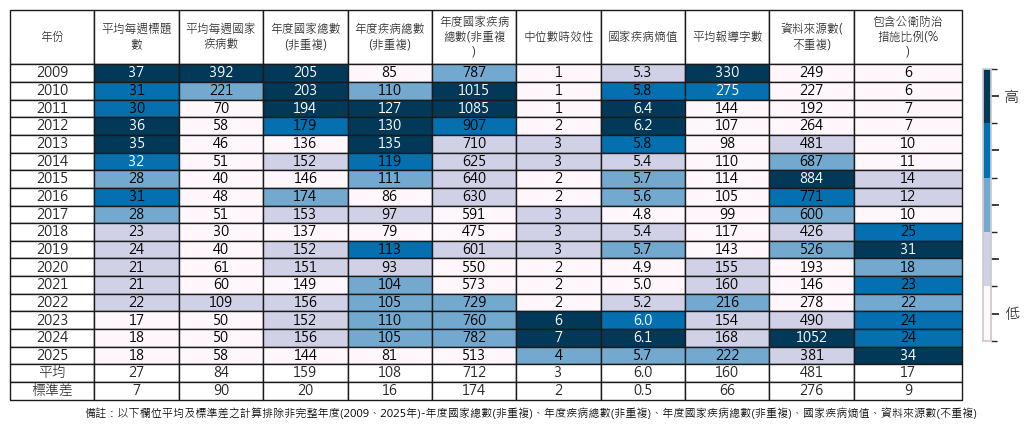

In [72]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS', 'sans-serif']
# ===== 可調參數 =====
CMAP_NAME = 'PuBu'   # 順序色帶
LEVELS = 5           # 5 階（最暗兩階 → 白字）

# 取得離散 colormap
cmap = plt.cm.get_cmap(CMAP_NAME, LEVELS)

# 顏色矩陣（先全白）
cell_colors = np.full((summary_table_1.shape[0], summary_table_1.shape[1]), 'white', dtype=object)

# 每欄各自 Normalize（排除最後兩列 Mean / Standard Deviation）
col_norms = [None] * summary_table_1.shape[1]
for col_idx in range(1, summary_table_1.shape[1]):  # 跳過第 1 欄（year）
    col_values = summary_table_1.iloc[:-2, col_idx]
    norm = plt.Normalize(col_values.min(), col_values.max())
    col_norms[col_idx] = norm

    # 著色
    for row_idx in range(summary_table_1.shape[0]):
        if summary_table_1.index[row_idx] in ['Mean', 'Standard Deviation']:
            continue
        val = summary_table_1.iloc[row_idx, col_idx]
        if np.isnan(val):  # 若可能有非數值，改用: if pd.isna(val):
            continue
        t = norm(val)                 # 0~1
        cell_colors[row_idx, col_idx] = cmap(t)




# 建圖與表格（加寬）
fig, ax = plt.subplots(figsize=(11.5, 4))
ax.axis('off')

# 欄名做換行 ---
labels = list(summary_table_1.columns)
if labels and labels[0].lower() == 'year':
    labels[0] = '年份'

def wrap_cjk(s, width=5):
    s = str(s)
    return "\n".join([s[i:i+width] for i in range(0, len(s), width)])
wrapped_col_labels = [labels[0]] + [wrap_cjk(c, width=6) for c in labels[1:]]


table = ax.table(
    cellText=summary_table_1.values,
    colLabels=wrapped_col_labels, # not raw summary_table_1.columns
    cellLoc='center',
    loc='center',
    cellColours=cell_colors
)


# === 右側專屬 colorbar Axes（不擠壓主圖） ===
boundaries = np.linspace(0, 1, LEVELS + 1)                  # 0,0.2,...,1
norm_legend = mpl.colors.BoundaryNorm(boundaries, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm_legend)
sm.set_array([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=1.1)    # 調整寬度/間距
tick_centers = (boundaries[:-1] + boundaries[1:]) / 2

cbar = fig.colorbar(sm, cax=cax, ticks=tick_centers)
cbar.ax.set_yticklabels(['低', '', '', '', '高'])
# cbar.set_label('相對大小（每欄各自正規化）', rotation=90)

# 最暗兩階改白字（5 階 → index 3、4）
dark_threshold = LEVELS - 2
for col_idx in range(1, summary_table_1.shape[1]):
    norm = col_norms[col_idx]
    if norm is None:
        continue
    for row_idx in range(summary_table_1.shape[0]):
        if summary_table_1.index[row_idx] in ['Mean', 'Standard Deviation']:
            continue
        val = summary_table_1.iloc[row_idx, col_idx]
        if np.isnan(val):
            continue
        t = float(norm(val))
        level_idx = int(np.floor(t * (LEVELS - 1) + 1e-9))  # 0..LEVELS-1
        # 注意：table 的 (row, col) 0 列是表頭，所以資料列 +1
        txt = table[(row_idx + 1, col_idx)].get_text()
        txt.set_color('white' if level_idx >= dark_threshold else 'black')

# 排版
table.auto_set_font_size(False)
# table.set_fontsize(10)

body_fs = 10
header_fs = 8.5
table.auto_set_font_size(False)
table.set_fontsize(body_fs)
for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.get_text().set_fontsize(header_fs)

table.scale(1.2, 1.2)

# 表頭增高
for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.set_height(0.2)

# 需要的話調某欄(transmission route)寬
for (r, c), cell in table.get_celld().items():
    if c == 10:
        cell.set_width(0.14)

# 底部留空放註記（right 不用動，主圖不會被色條擠）
fig.subplots_adjust(bottom=0.20)
fig.text(
    0.5, 0.002,
    '備註：以下欄位平均及標準差之計算排除非完整年度(2009、2025年)-年度國家總數(非重複)、年度疾病總數(非重複)、年度國家疾病總數(非重複)、國家疾病熵值、資料來源數(不重複)',
    ha='center', va='bottom', fontsize=8, color='black'
)

plt.savefig("output/plot/Table_1_summary_statistics.png", dpi=300, bbox_inches='tight')
plt.show()


### Adds-on: Singapore in splotlight

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_54692\1267458867.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



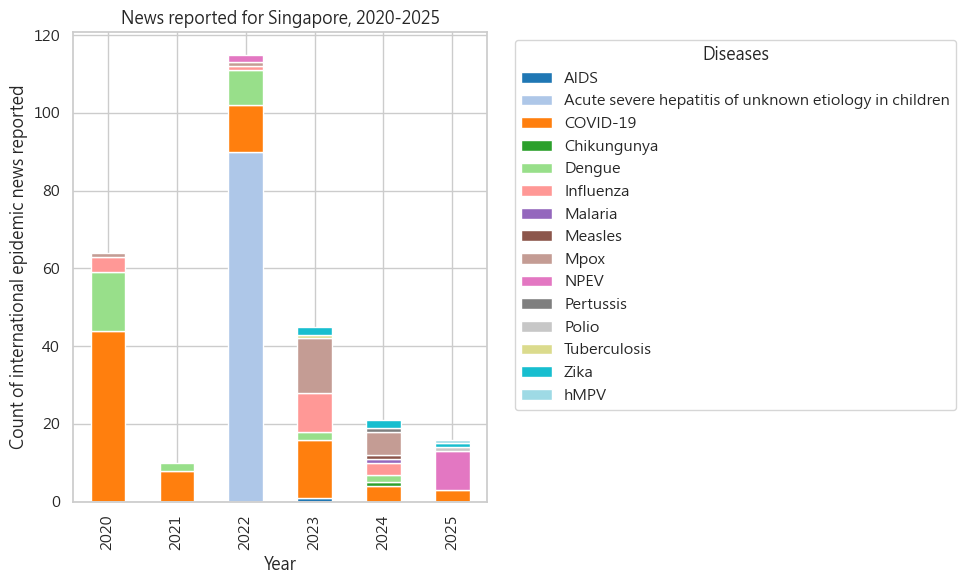

Source_list
who                    108
us cdc                  87
ecdc                    84
印尼衛生部                   49
巴西衛生部                   42
墨西哥衛生部                  39
日本厚勞省                   36
okezone news            25
西班牙衛生部                  23
outbreak news today     23
韓國疾管廳                   20
新加坡衛生部                  17
新加坡環境局                  16
新加坡疾管局                  12
香港衛生署                    8
韓聯社聯合新聞                  8
日本國立健康危機管理研究機構           8
韓國疾管局                    8
香港衛生防護中心                 7
cidrap                   6
韓聯社                      5
泰國衛生部                    5
加拿大衛生部                   5
paho                     4
cnn indonesia            4
新加坡環境部                   4
新加坡衛生部新冠統計               4
大韓民國政策新聞                 4
印尼疾控總局                   4
馬來西亞衛生部                  4
本署監測資料                   3
antaranews               3
中國疾控中心                   3
cna                      2
us cdc 新冠監測              2
路透社                      2
新加坡衛生部 w15      

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


df_sgp = df[(df["country_iso3"]=='SGP') & (df["year"]>=2020)][["country_name_en","disease_name_en","year","description","Source_list"]]


counts_by_year_disease = df_sgp.groupby(["year", "disease_name_en"]).size().unstack(fill_value=0)

num_diseases = counts_by_year_disease.shape[1]

colors = cm.get_cmap("tab20", num_diseases)(np.arange(num_diseases))

counts_by_year_disease.plot(
    kind="bar", 
    stacked=True, 
    figsize=(10, 6), 
    color=colors)

plt.title("News reported for Singapore, 2020-2025")
plt.xlabel("Year")
plt.ylabel("Count of international epidemic news reported")
plt.legend(title="Diseases", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig("Output/plot/Singapore_disease_news_reported_2020_2025.png", dpi=300)

plt.show()

### Sources for Singapore ###
table_source_explode_sgp = pd.DataFrame({'Source_list': df_sgp['Source_list']}).explode('Source_list')

counts_table_source_sgp = table_source_explode_sgp['Source_list'].dropna().value_counts()

print(counts_table_source_sgp.head(40))


### US in spotlight

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_54692\3442665827.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



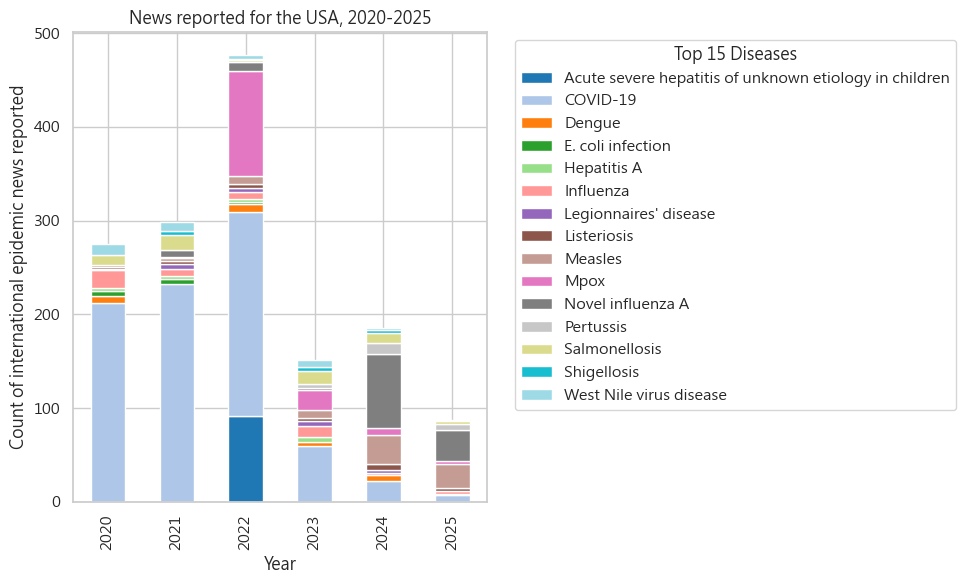

Source_list
who                    108
us cdc                  87
ecdc                    84
印尼衛生部                   49
巴西衛生部                   42
墨西哥衛生部                  39
日本厚勞省                   36
okezone news            25
西班牙衛生部                  23
outbreak news today     23
韓國疾管廳                   20
新加坡衛生部                  17
新加坡環境局                  16
新加坡疾管局                  12
香港衛生署                    8
韓聯社聯合新聞                  8
日本國立健康危機管理研究機構           8
韓國疾管局                    8
香港衛生防護中心                 7
cidrap                   6
韓聯社                      5
泰國衛生部                    5
加拿大衛生部                   5
paho                     4
cnn indonesia            4
新加坡環境部                   4
新加坡衛生部新冠統計               4
大韓民國政策新聞                 4
印尼疾控總局                   4
馬來西亞衛生部                  4
本署監測資料                   3
antaranews               3
中國疾控中心                   3
cna                      2
us cdc 新冠監測              2
路透社                      2
新加坡衛生部 w15      

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


df_usa = df[(df["country_iso3"]=='USA') & (df["year"]>=2020)][["country_name_en","disease_name_en","year","description","Source_list"]]

top_diseases_USA = df_usa['disease_name_en'].value_counts().nlargest(15).index

# 2. Filter the df_usa DataFrame to keep only the rows where the disease name is in your top 20 list
df_usa = df_usa[df_usa['disease_name_en'].isin(top_diseases_USA)]



counts_by_year_disease = df_usa.groupby(["year", "disease_name_en"]).size().unstack(fill_value=0)

num_diseases = counts_by_year_disease.shape[1]

colors = cm.get_cmap("tab20", num_diseases)(np.arange(num_diseases))

counts_by_year_disease.plot(
    kind="bar", 
    stacked=True, 
    figsize=(10, 6), 
    color=colors)

plt.title("News reported for the USA, 2020-2025")
plt.xlabel("Year")
plt.ylabel("Count of international epidemic news reported")
plt.legend(title="Top 15 Diseases", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

#plt.savefig("Output/plot/USA_disease_news_reported_2020_2025.png", dpi=300)

plt.show()

### Sources for Singapore ###
table_source_explode_sgp = pd.DataFrame({'Source_list': df_sgp['Source_list']}).explode('Source_list')

counts_table_source_sgp = table_source_explode_sgp['Source_list'].dropna().value_counts()

print(counts_table_source_sgp.head(40))

# Graph 4: PHEIC summary
For each disease, mark the frist CDC-report date,  PHEIC announance date, PHEIC end date, research end date

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
df_plot = df.copy()
# (1) PHEIC timing 
table_PHEIC_timeline = pd.DataFrame({
    'PHEIC_name': [
        'H5N1流感',
        '小兒麻痺症',
        '伊波拉病毒感染(西非)',
        '茲卡病毒感染症',
        '伊波拉病毒感染(剛果民主共和國)',
        'COVID-19',
        'M痘(II型)',
        'M痘(Ib型)'],
    'disease_name': [
        '新型A型流感/禽類禽流感',
        '小兒麻痺症',
        '伊波拉病毒感染',
        '茲卡病毒感染症',
        '伊波拉病毒感染',
        'COVID-19',
        'M痘',
        'M痘'],
    'date_PHEIC_start': [ #references
        '2009-04-25', # https://www.who.int/groups/h1n1-ihr-emergency-committee
        '2014-05-05', # https://polioeradication.org/public-health-emergency-status/
        '2014-08-08', # https://news.un.org/en/story/2014/08/474732#:~:text=Based%20on%20the%20advice%20of%20the%20Executive%20Committee%2C,a%20Public%20Health%20Emergency%20of%20International%20Concern%20%28PHEIC%29.%E2%80%9D
        '2016-02-01', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2019-07-17', # https://www.who.int/news/item/17-07-2019-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-a-public-health-emergency-of-international-concern
        '2020-01-30', # https://www.who.int/publications/m/item/covid-19-public-health-emergency-of-international-concern-%28pheic%29-global-research-and-innovation-forum
        '2022-07-23', # https://www.who.int/groups/monkeypox-ihr-emergency-committee#:~:text=On%2023%20July%202022%2C%20the%20WHO%20Director-General%20determined,and%20issued%20Temporary%20Recommendations%20to%20States%20Parties%20accordingly.
        '2024-08-14'],# https://www.who.int/news/item/19-08-2024-first-meeting-of-the-international-health-regulations-(2005)-emergency-committee-regarding-the-upsurge-of-mpox-2024#:~:text=The%20Director-General%20of%20the%20World%20Health%20Organization%20%28WHO%29%2C,concern%20%28PHEIC%29%20under%20the%20provisions%20of%20the%20Regulations. 
    'date_PHEIC_end': [
        '2010-08-10', # https://www.who.int/news/item/10-08-2010-director-general-statement-following-the-ninth-meeting-of-the-emergency-committee
        None,
        '2016-03-29', # https://www.who.int/news/item/29-03-2016-statement-on-the-9th-meeting-of-the-ihr-emergency-committee-regarding-the-ebola-outbreak-in-west-africa
        '2016-11-18', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2020-06-25', # https://www.who.int/news/item/25-06-2020-10th-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-over-vigilance-against-flare-ups-and-support-for-survivors-must-continue
        '2023-05-05', # https://www.who.int/news/item/05-05-2023-statement-on-the-fifteenth-meeting-of-the-international-health-regulations-%282005%29-emergency-committee-regarding-the-coronavirus-disease-%28covid-19%29-pandemic
        '2023-05-11', # https://www.paho.org/en/news/11-5-2023-who-declares-end-mpox-emergency-calls-sustained-efforts-long-term-management-disease#:~:text=May%2011%2C%202023-%20The%20Emergency%20Committee%20on%20monkeypox,Concern%20%28PHEIC%29%2C%20given%20the%20sustained%20decline%20in%20cases.
        '2025-09-05'],#https://healthpolicy-watch.news/who-ends-international-emergency-declaration-for-mpox-but-vigilance-still-needed/
    'date_study_end' : [research_end_date] * 8
})

#print(table_PHEIC_timeline)

# (2) clean PHEIC subset and get the earlist reporting date
list_PHEIC_diseases = ["COVID-19","新型A型流感","禽類禽流感","小兒麻痺症","伊波拉病毒感染","M痘","茲卡病毒感染症"]


df_PHEIC = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_PHEIC = df_PHEIC[['disease_name','date',"country_name_zh","country_iso3","description","disease_name_en"]]

df_PHEIC.loc[df_PHEIC['disease_name'].isin(['新型A型流感', '禽類禽流感']), 'disease_name'
             ] = '新型A型流感/禽類禽流感'
df_PHEIC.loc[df_PHEIC['disease_name_en'].isin(['Novel influenza A', 'Avian influenza (animal)']), 'disease_name_en'
             ] = 'Novel influenza A'

df_PHEIC['date'] = pd.to_datetime(df_plot['date'])
df_PHEIC = df_PHEIC.sort_values(by='date')
df_PHEIC_earliest = df_PHEIC.groupby(['disease_name','disease_name_en']).first().reset_index().rename(columns={'date': 'date_CDC_initial_alert'})

# (3) merge earlist reporting date to timeline
table_PHEIC_timeline = pd.merge(
    table_PHEIC_timeline,
    df_PHEIC_earliest[['disease_name','disease_name_en','date_CDC_initial_alert','description']],
    on='disease_name',
    how='left')


print(table_PHEIC_timeline)
# date formatting
for col in ['date_CDC_initial_alert', 'date_PHEIC_start', 'date_PHEIC_end', 'date_study_end']:
    table_PHEIC_timeline[col] = pd.to_datetime(table_PHEIC_timeline[col])

df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# (4) pivot as a flat with shared disease_name ###
table_PHEIC_timeline["event_number"] = table_PHEIC_timeline.groupby("disease_name").cumcount() + 1

# Pivot start and end dates
pivoted = table_PHEIC_timeline.pivot(
    index=["disease_name", "disease_name_en","date_study_end", "date_CDC_initial_alert"],
    columns="event_number",
    values=["PHEIC_name","date_PHEIC_start", "date_PHEIC_end"])


pivoted.columns = [f"{col}_{num}" for col, num in pivoted.columns]
table_PHEIC_timeline = pivoted.reset_index()

print(table_PHEIC_timeline)


         PHEIC_name  disease_name date_PHEIC_start date_PHEIC_end  \
0            H5N1流感  新型A型流感/禽類禽流感       2009-04-25     2010-08-10   
1             小兒麻痺症         小兒麻痺症       2014-05-05           None   
2       伊波拉病毒感染(西非)       伊波拉病毒感染       2014-08-08     2016-03-29   
3           茲卡病毒感染症       茲卡病毒感染症       2016-02-01     2016-11-18   
4  伊波拉病毒感染(剛果民主共和國)       伊波拉病毒感染       2019-07-17     2020-06-25   
5          COVID-19      COVID-19       2020-01-30     2023-05-05   
6           M痘(II型)            M痘       2022-07-23     2023-05-11   
7           M痘(Ib型)            M痘       2024-08-14     2025-09-05   

  date_study_end    disease_name_en date_CDC_initial_alert  \
0     2025-12-31  Novel influenza A             2009-01-05   
1     2025-12-31              Polio             2009-01-06   
2     2025-12-31              Ebola             2009-01-05   
3     2025-12-31               Zika             2015-11-02   
4     2025-12-31              Ebola             2009-01-05   
5     

### summary table
By disease_name, instead of PHEIC_name

In [11]:
def compute_avg_obs(subset, start, end, fallback_end):
    if pd.isnull(start):
        return None
    if pd.isnull(end):
        end = fallback_end
    interval = (end - start).days
    between = subset[(subset["date"] >= start) & (subset["date"] < end)]
    weeks = max(interval / 7, 1)
    return round(len(between) / weeks, 1)

# Main metric calculator
def calculate_metrics(row):
    disease = row['disease_name']
    alert = row['date_CDC_initial_alert']
    study_end = row['date_study_end']
    s1 = row['date_PHEIC_start_1']
    e1 = row['date_PHEIC_end_1']
    s2 = row['date_PHEIC_start_2']
    e2 = row['date_PHEIC_end_2']

    subset = df_PHEIC[df_PHEIC["disease_name"] == disease]
    result = {}

    # Interval days: alert → start_1
    result['interval_days_alert_to_start_1'] = (s1 - alert).days if pd.notnull(alert) and pd.notnull(s1) else None

    # Weekly obs: alert → start_1
    result['avg_obs_alert_to_start_1'] = compute_avg_obs(subset, alert, s1, study_end)
    # Weekly obs: start_1 → end_1
    result['avg_obs_start_to_end_1'] = compute_avg_obs(subset, s1, e1, study_end)

    if disease in ["M痘", "伊波拉病毒感染"]:
        # Weekly obs: end_1 → start_2
        result['avg_obs_end1_to_start2'] = compute_avg_obs(subset, e1, s2, study_end)
        # Weekly obs: start_2 → end_2
        result['avg_obs_start2_to_end2'] = compute_avg_obs(subset, s2, e2, study_end)
        # Weekly obs: end_2 → study_end
        result['avg_obs_end2_to_study'] = compute_avg_obs(subset, e2, study_end, study_end)
    else:
        # Weekly obs: end_1 → study_end
        result['avg_obs_end1_to_study'] = compute_avg_obs(subset, e1, study_end, study_end)

    return pd.Series(result)

# Apply and combine
metrics_cleaned = table_PHEIC_timeline.apply(calculate_metrics, axis=1)
table_PHEIC_summary = pd.concat([table_PHEIC_timeline, metrics_cleaned], axis=1)

print(table_PHEIC_summary.head())
#table_PHEIC_summary.to_excel("data/testPHEIC.xlsx", index=False)

   disease_name    disease_name_en date_study_end date_CDC_initial_alert  \
0      COVID-19           COVID-19     2025-12-31             2020-01-02   
1            M痘               Mpox     2025-12-31             2011-01-14   
2       伊波拉病毒感染              Ebola     2025-12-31             2009-01-05   
3         小兒麻痺症              Polio     2025-12-31             2009-01-06   
4  新型A型流感/禽類禽流感  Novel influenza A     2025-12-31             2009-01-05   

  PHEIC_name_1      PHEIC_name_2 date_PHEIC_start_1 date_PHEIC_start_2  \
0     COVID-19               NaN         2020-01-30                NaT   
1      M痘(II型)           M痘(Ib型)         2022-07-23         2024-08-14   
2  伊波拉病毒感染(西非)  伊波拉病毒感染(剛果民主共和國)         2014-08-08         2019-07-17   
3        小兒麻痺症               NaN         2014-05-05                NaT   
4       H5N1流感               NaN         2009-04-25                NaT   

  date_PHEIC_end_1 date_PHEIC_end_2  avg_obs_alert_to_start_1  \
0       2023-05-05              N

### Time Series Visualisation in Mandarin
visuals in weekly

c:\Users\three\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


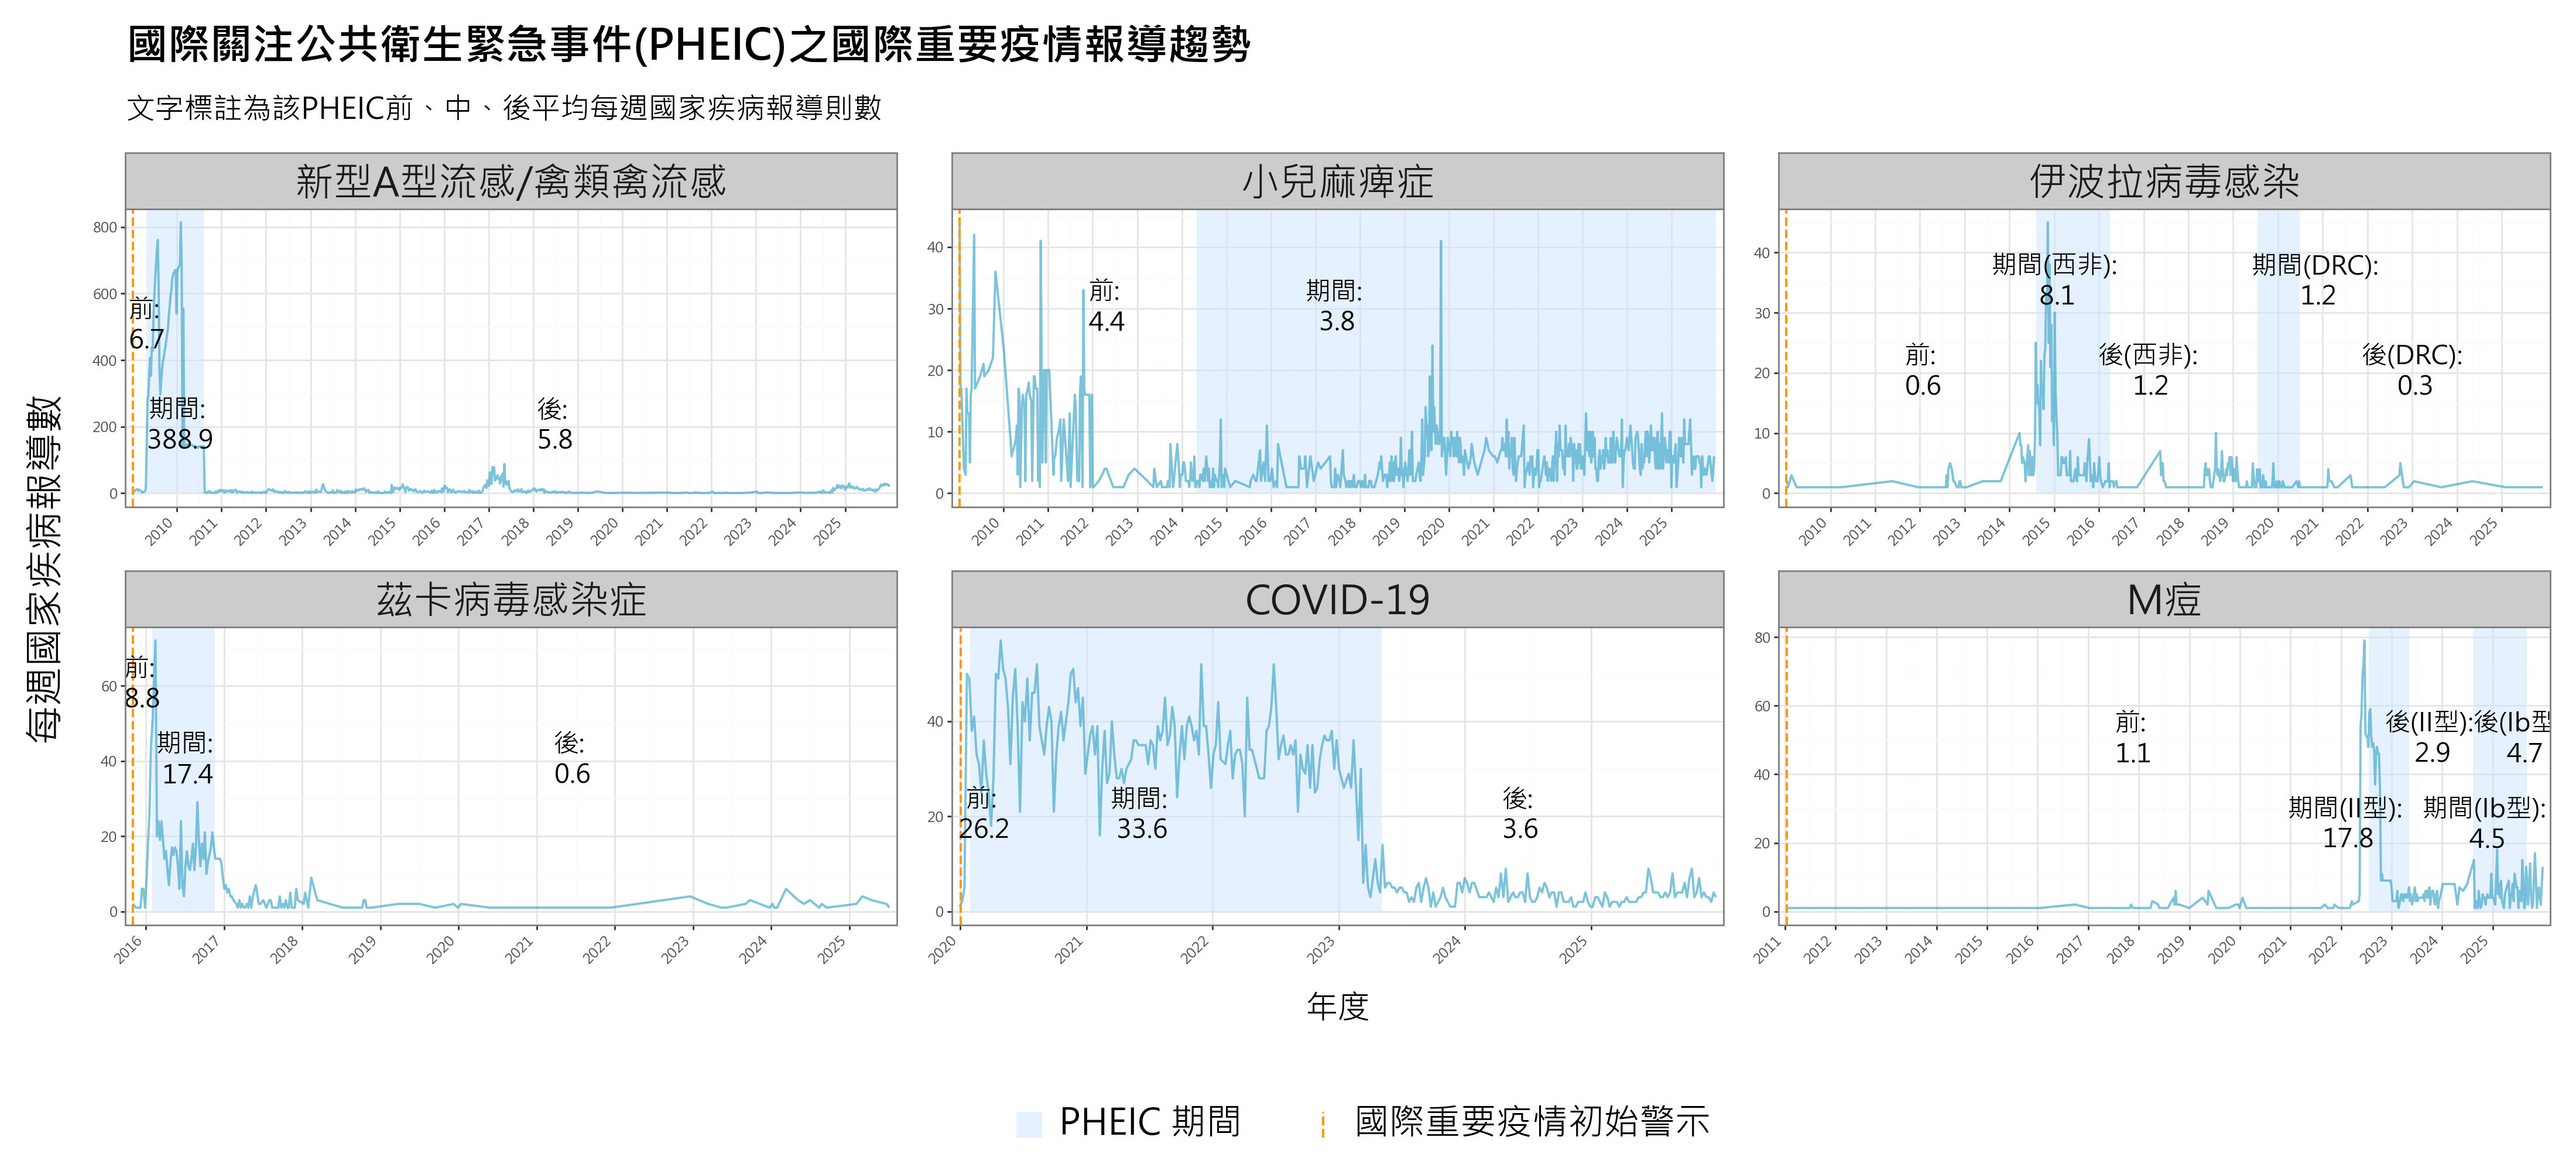

c:\Users\three\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 22 x 10 in image.
c:\Users\three\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: output/plot_publication/pheic_timeline_plot.png
c:\Users\three\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from plotnine import guide_legend, guides  # ← 需要這個
from pandas.api.types import CategoricalDtype
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# --- Make sure date columns are datetime ---
date_cols = [
    'date_CDC_initial_alert', 'date_PHEIC_start_1', 'date_PHEIC_end_1',
    'date_PHEIC_start_2', 'date_PHEIC_end_2', 'date_study_end'
]
for col in date_cols:
    table_PHEIC_summary[col] = pd.to_datetime(table_PHEIC_summary[col])
df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# --- Group for plot ---
df_PHEIC['week'] = df_PHEIC['date'].dt.to_period('W').apply(lambda r: r.start_time)
df_plot_grouped = (
    df_PHEIC
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
    .rename(columns={'week': 'date'})
)

### Manual Annotations ###
annotation_config = [
    ('M痘',            '2017-11-01', 50, "前", 'avg_obs_alert_to_start_1'),
    ('M痘',            '2022-02-01', 25, "期間(II型)", 'avg_obs_start_to_end_1'),
    ('M痘',            '2023-10-01', 50, "後(II型)", 'avg_obs_end1_to_start2'),
    ('M痘',            '2024-11-01', 25, "期間(Ib型)", 'avg_obs_start2_to_end2'),
    ('M痘',            '2025-08-01', 50, "後(Ib型)", 'avg_obs_end2_to_study'),
    ('COVID-19',       '2020-03-01', 20, "前", 'avg_obs_alert_to_start_1'),
    ('COVID-19',       '2021-06-01', 20, "期間", 'avg_obs_start_to_end_1'),
    ('COVID-19',       '2024-06-01', 20, "後", 'avg_obs_end1_to_study'),
    ('小兒麻痺症',     '2012-04-01', 30, "前", 'avg_obs_alert_to_start_1'),
    ('小兒麻痺症',     '2017-06-01', 30, "期間", 'avg_obs_start_to_end_1'),
    ('新型A型流感/禽類禽流感', '2009-04-01', 500, "前", 'avg_obs_alert_to_start_1'),
    ('新型A型流感/禽類禽流感', '2010-01-01', 200, "期間", 'avg_obs_start_to_end_1'),
    ('新型A型流感/禽類禽流感', '2018-06-01', 200, "後", 'avg_obs_end1_to_study'),
    ('茲卡病毒感染症', '2015-12-01', 60, "前", 'avg_obs_alert_to_start_1'),
    ('茲卡病毒感染症', '2016-07-01', 40, "期間", 'avg_obs_start_to_end_1'),
    ('茲卡病毒感染症', '2021-06-01', 40, "後", 'avg_obs_end1_to_study'),
    ('伊波拉病毒感染', '2012-01-01', 20, "前", 'avg_obs_alert_to_start_1'),
    ('伊波拉病毒感染', '2015-01-01', 35, "期間(西非)", 'avg_obs_start_to_end_1'),
    ('伊波拉病毒感染', '2017-02-01', 20, "後(西非)", 'avg_obs_end1_to_start2'),
    ('伊波拉病毒感染', '2020-11-01', 35, "期間(DRC)", 'avg_obs_start2_to_end2'),
    ('伊波拉病毒感染', '2023-01-01', 20, "後(DRC)", 'avg_obs_end2_to_study'),
]

custom_annotations = []
for disease, x_str, y, label_prefix, col in annotation_config:
    x = pd.to_datetime(x_str)
    value = table_PHEIC_summary.loc[
        table_PHEIC_summary['disease_name'] == disease, col
    ].values
    if len(value) > 0 and not pd.isnull(value[0]):
        text = f"{label_prefix}:\n {round(value[0], 2)}"
        custom_annotations.append({
            'disease_name': disease,
            'x': x,
            'y': y,
            'label': text,
            'color': '#000000'
        })
df_annotations = pd.DataFrame(custom_annotations)

# --- Vertical alert lines only ---
df_lines = table_PHEIC_summary[['disease_name', 'date_CDC_initial_alert']].copy()
df_lines = df_lines.rename(columns={'date_CDC_initial_alert': 'date'})
df_lines['line_type'] = '國際重要疫情初始警示'  # ★ 新增：用來做圖例的類別標籤

# --- Background ribbons for PHEIC periods ---
def make_band(row):
    disease = row['disease_name']
    study_end = row['date_study_end']
    bands = []
    if pd.notnull(row['date_PHEIC_start_1']):
        end1 = row['date_PHEIC_end_1'] if pd.notnull(row['date_PHEIC_end_1']) else (
            study_end if disease == "小兒麻痺症" else None
        )
        if end1:
            bands.append({'disease_name': disease, 'start': row['date_PHEIC_start_1'], 'end': end1})
    if disease in ["M痘", "伊波拉病毒感染"] and pd.notnull(row['date_PHEIC_start_2']):
        end2 = row['date_PHEIC_end_2'] if pd.notnull(row['date_PHEIC_end_2']) else study_end
        bands.append({'disease_name': disease, 'start': row['date_PHEIC_start_2'], 'end': end2})
    return bands

background_bands = pd.DataFrame([
    band for _, row in table_PHEIC_summary.iterrows() for band in make_band(row)
])
background_bands['label_bg'] = 'PHEIC 期間'

# panel order
desired_order = ['新型A型流感/禽類禽流感','小兒麻痺症','伊波拉病毒感染','茲卡病毒感染症','COVID-19','M痘']
disease_type = CategoricalDtype(categories=desired_order, ordered=True)
for df_ in [df_plot_grouped, df_annotations, df_lines, background_bands]:
    df_['disease_name'] = df_['disease_name'].astype(disease_type)

# -----------------------
# 建圖（新增 color/linetype 的映射與比例尺）
# -----------------------
p = (
    ggplot(df_plot_grouped, aes(x='date', y='count')) +
    facet_wrap('~disease_name', scales='free', nrow=2, ncol=3) +

    # 背景帶狀區
    geom_rect(
        background_bands,
        aes(xmin='start', xmax='end', ymin=0, ymax=float('inf'), fill='label_bg'),
        alpha=0.5, inherit_aes=False
    ) +

    # 折線
    geom_line(aes(x='date', y='count'), color="#42A8CAAF", size=0.8) +

    # ★ CDC 初始警示線：用 color 與 linetype 映射到分類，才能出現在圖例
    geom_vline(
        df_lines,
        aes(xintercept='date', color='line_type', linetype='line_type'),
        size=0.8
    ) +

    # 註解
    geom_text(
        df_annotations,
        aes(x='x', y='y', label='label'),
        color='#000000', size=16, show_legend=False
    ) +
    scale_x_datetime(# every year tick
    breaks=pd.date_range(
        df_plot_grouped['date'].min().normalize(),
        df_plot_grouped['date'].max().normalize(),
        freq='YS'
    ),
    labels=date_format("%Y"),
    expand=(0.01, 0.01))+

    labs(
        title='國際關注公共衛生緊急事件(PHEIC)之國際重要疫情報導趨勢',
        subtitle='文字標註為該PHEIC前、中、後平均每週國家疾病報導則數',
        x='年度', y='每週國家疾病報導數',
        fill ='',
        linetype='',
         color=''
    ) +

    # ★ 圖例：填色（背景帶）與線條（CDC 初始警示）
    scale_fill_manual(
        values={'PHEIC 期間': '#cce5ff'},
        guide=guide_legend(title='')
    ) +
    scale_color_manual(
        values={'國際重要疫情初始警示': '#FE9900'},   # ← 黃色
        guide=guide_legend(title='')
    ) +
    scale_linetype_manual(
        values={'國際重要疫情初始警示': 'dashed'},    # ← 虛線
        guide=guide_legend(title='')
    ) +

    # ★ 讓兩個圖例同時顯示並可控制順序（fill 在上、line 在下）
    guides(
        fill=guide_legend(order=1),
        color=guide_legend(order=2),
        linetype=guide_legend(order=2)
    ) +

    theme_bw() +
    theme(
        figure_size=(22, 10),
        legend_position='bottom',             
        axis_text_x=element_text(rotation=45, hjust=1),
        subplots_adjust={'wspace': 0.25},
        text=element_text(family="Microsoft JhengHei"),
        strip_text=element_text(size=24),
        legend_text=element_text(size=22),
        plot_title=element_text(size=26, weight='bold'),
        plot_subtitle=element_text(size=18),
        axis_title_y=element_text(size=24),
        axis_title_x=element_text(size=20)
    )
)

p.show()
p.save("output/plot_publication/pheic_timeline_plot.png", width=22, height=10, dpi=300, units='in')

### Time series Visualisation in English

c:\Users\kaitseng\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


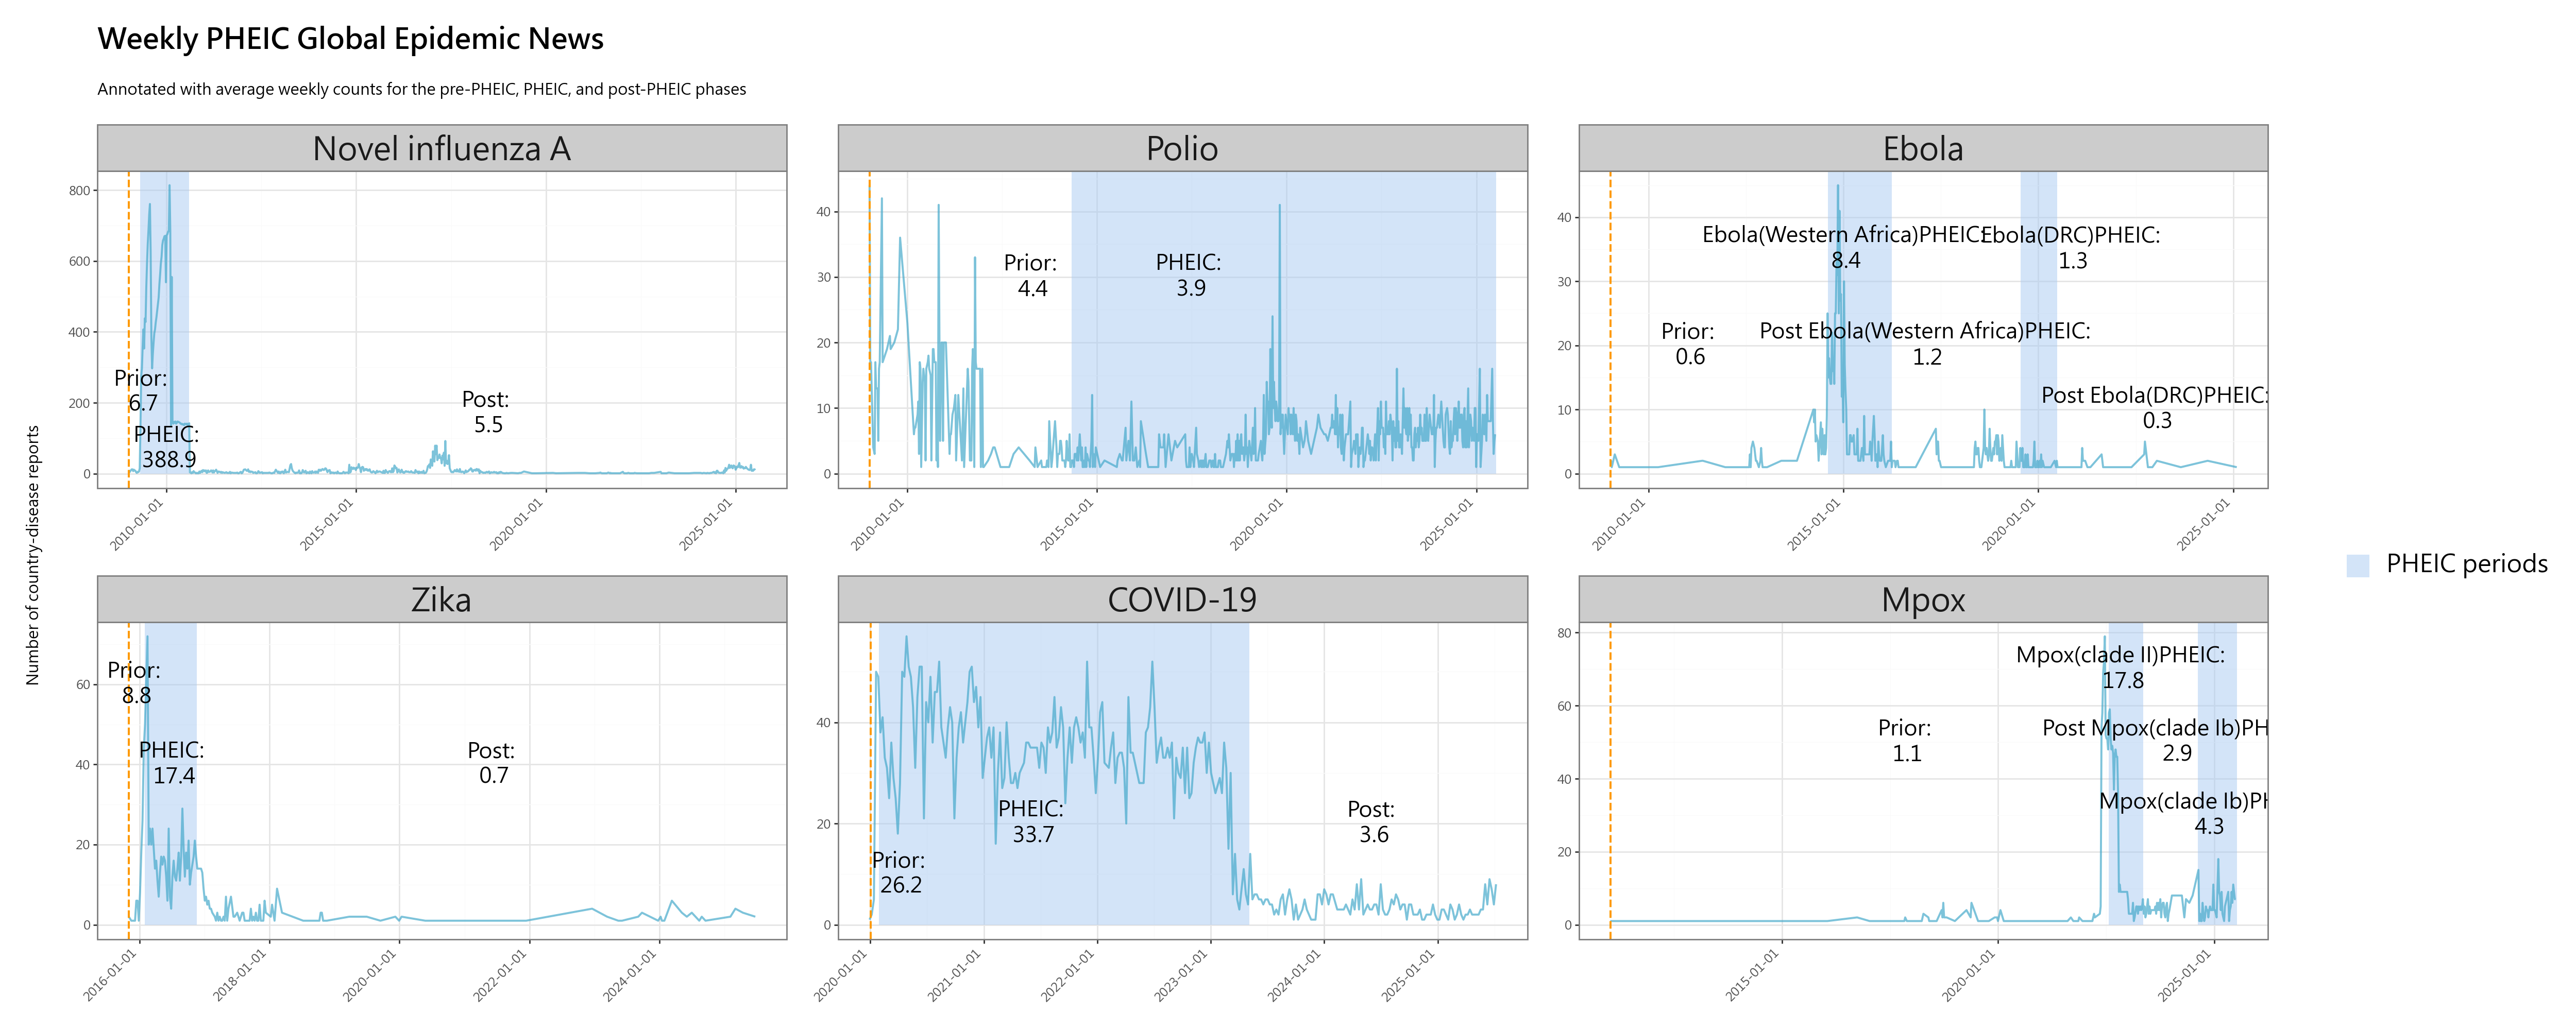

c:\Users\kaitseng\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 25 x 10 in image.
c:\Users\kaitseng\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: output/plot/pheic_timeline_plot_en.png
c:\Users\kaitseng\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from pandas.api.types import CategoricalDtype
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# --- Make sure date columns are datetime ---
date_cols = [
    'date_CDC_initial_alert', 'date_PHEIC_start_1', 'date_PHEIC_end_1',
    'date_PHEIC_start_2', 'date_PHEIC_end_2', 'date_study_end']
for col in date_cols:
    table_PHEIC_summary[col] = pd.to_datetime(table_PHEIC_summary[col])
df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# --- Group for plot ---


df_PHEIC['week'] = df_PHEIC['date'].dt.to_period('W').apply(lambda r: r.start_time)

df_plot_grouped = (
    df_PHEIC
    .groupby(['disease_name_en', 'week'])
    .size()
    .reset_index(name='count')
    .rename(columns={'week': 'date'})  # for consistency with plotting code
)


### Manual Annotations ###
annotation_config = [
    # disease_name,        x,                  y,      label_text,                          column_name
    ('Mpox',            '2017-11-01',          50,     "Prior",                         'avg_obs_alert_to_start_1'),
    ('Mpox',            '2022-11-01',          70,     "Mpox(clade II)PHEIC",                'avg_obs_start_to_end_1'),
    ('Mpox',            '2024-02-01',          50,     "Post Mpox(clade Ib)PHEIC",              'avg_obs_end1_to_start2'),
    ('Mpox',            '2024-11-01',          30,     "Mpox(clade Ib)PHEIC",                'avg_obs_start2_to_end2'),
    ('COVID-19',       '2020-04-01',          10,     "Prior",                         'avg_obs_alert_to_start_1'),
    ('COVID-19',       '2021-06-01',          20,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('COVID-19',       '2024-06-01',          20,     "Post",                         'avg_obs_end1_to_study'),
    ('Polio',     '2013-04-01',          30,     "Prior",                         'avg_obs_alert_to_start_1'),
    ('Polio',     '2017-06-01',          30,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Novel influenza A', '2009-05-01', 230,   "Prior",                         'avg_obs_alert_to_start_1'),
    ('Novel influenza A', '2010-01-01', 70,    "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Novel influenza A', '2018-06-01', 170,   "Post",                         'avg_obs_end1_to_study'),
    ('Zika', '2015-12-01',          60,     "Prior",                         'avg_obs_alert_to_start_1'),
    ('Zika', '2016-07-01',          40,     "PHEIC",                           'avg_obs_start_to_end_1'),
    ('Zika', '2021-06-01',          40,     "Post",                         'avg_obs_end1_to_study'),
    ('Ebola', '2011-01-01',          20,     "Prior",                         'avg_obs_alert_to_start_1'),
    ('Ebola', '2015-01-01',          35,     "Ebola(Western Africa)PHEIC",             'avg_obs_start_to_end_1'),
    ('Ebola', '2017-02-01',          20,     "Post Ebola(Western Africa)PHEIC",          'avg_obs_end1_to_start2'),
    ('Ebola', '2020-11-01',          35,     "Ebola(DRC)PHEIC",             'avg_obs_start2_to_end2'),
    ('Ebola', '2023-01-01',          10,     "Post Ebola(DRC)PHEIC",          'avg_obs_end2_to_study'),
]

custom_annotations = []
for disease, x_str, y, label_prefix, col in annotation_config:
    x = pd.to_datetime(x_str)
    value = table_PHEIC_summary.loc[
        table_PHEIC_summary['disease_name_en'] == disease, col].values
    if len(value) > 0 and not pd.isnull(value[0]):
        text = f"{label_prefix}:\n {round(value[0], 2)}"
        custom_annotations.append({
            'disease_name_en': disease,
            'x': x,
            'y': y,
            'label': text,
            'color': '#000000'
        })

df_annotations = pd.DataFrame(custom_annotations)



# --- Vertical alert lines only ---
df_lines = table_PHEIC_summary[['disease_name_en', 'date_CDC_initial_alert']].copy()
df_lines = df_lines.rename(columns={'date_CDC_initial_alert': 'date'})
df_lines['line_type'] = 'CDC_alert'

# --- Background ribbons for PHEIC periods ---
def make_band(row):
    disease = row['disease_name_en']
    study_end = row['date_study_end']
    bands = []

    # PHEIC phase 1
    if pd.notnull(row['date_PHEIC_start_1']):
        end1 = row['date_PHEIC_end_1'] if pd.notnull(row['date_PHEIC_end_1']) else (
            study_end if disease == "Polio" else None
        )
        if end1:
            bands.append({
                'disease_name_en': disease,
                'start': row['date_PHEIC_start_1'],
                'end': end1
            })

    # PHEIC phase 2 (only for M痘 伊波拉病毒感染)
    if disease in ["Mpox","Ebola"] and pd.notnull(row['date_PHEIC_start_2']):
        end2 = row['date_PHEIC_end_2'] if pd.notnull(row['date_PHEIC_end_2']) else study_end
        bands.append({
            'disease_name_en': disease,
            'start': row['date_PHEIC_start_2'],
            'end': end2
        })

    return bands

background_bands = pd.DataFrame([
    band for _, row in table_PHEIC_summary.iterrows()
    for band in make_band(row)
])
background_bands['label_bg'] = 'PHEIC periods'

# pandel order
desired_order = ['Novel influenza A','Polio','Ebola','Zika','COVID-19','Mpox']
disease_type = CategoricalDtype(categories=desired_order, ordered=True)
for df in [df_plot_grouped, df_annotations, df_lines, background_bands]:
    df['disease_name_en'] = df['disease_name_en'].astype(disease_type)



p = (
    ggplot(df_plot_grouped, aes(x='date', y='count')) +
    facet_wrap('~disease_name_en', scales='free', nrow=2, ncol=3) +

    # Background shaded rectangles
    geom_rect(background_bands, aes(xmin='start', xmax='end', ymin=0, ymax=float('inf'), fill = 'label_bg'), # inf to be flexible to each maximum
               alpha=0.5, inherit_aes=False) +

   # geom_point(aes(size='count'), alpha=0.5, color='#1f78b4') +
    geom_line(aes(x='date', y='count'), color="#42A8CAAF", size=0.8) +
    # geom_area(aes(x='date', y='count'), fill='#9ecae1', alpha=0.6) +
    #geom_step(aes(x='date', y='count'), direction='mid', color='#060270')+

    # Alert lines
    geom_vline(df_lines, aes(xintercept='date'), linetype='dashed', size=0.8, color='#FE9900') +

    # Annotations
    geom_text(df_annotations,
          aes(x='x', y='y', label='label'), color='#000000',
          size=15, show_legend=False) +


    
    labs(title='Weekly PHEIC Global Epidemic News', x='', y='Number of country-disease reports', subtitle= "Annotated with average weekly counts for the pre-PHEIC, PHEIC, and post-PHEIC phases") +
    scale_fill_manual(values={'PHEIC periods': "#a8caf2"}, 
                      guide=guide_legend(title=''))+
    theme_bw() +
    theme(
        figure_size=(25, 10),
        axis_text_x=element_text(rotation=45, hjust=1),
        subplots_adjust={'wspace': 0.25},
        text=element_text(family="Microsoft JhengHei"),
        strip_text=element_text(size=22),
        legend_text=element_text(size=17),
        plot_title=element_text(size=20, weight='bold') 
         )
       
)

p.show()


p.save("output/plot/pheic_timeline_plot_en.png", width=25, height=10, dpi=300, units='in')



### Negative Binomial modelling

In [29]:
# -*- coding: utf-8 -*-
# ========= PHEIC Negative Binomial GLM (simple core version) =========
# Requirements: pandas, numpy, statsmodels

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --------------------------------------------------------------------
# 0) Ensure datetime dtypes
# --------------------------------------------------------------------
date_cols_timeline = [
    "date_CDC_initial_alert", "date_study_end",
    "date_PHEIC_start_1", "date_PHEIC_end_1",
    "date_PHEIC_start_2", "date_PHEIC_end_2"
]
for c in date_cols_timeline:
    if c in table_PHEIC_summary.columns:
        table_PHEIC_summary[c] = pd.to_datetime(table_PHEIC_summary[c], errors="coerce")

if "date" in df_PHEIC.columns:
    df_PHEIC["date"] = pd.to_datetime(df_PHEIC["date"], errors="coerce")

# --------------------------------------------------------------------
# 1) Build phase intervals (handles up to two PHEICs)
# --------------------------------------------------------------------
def build_intervals(row):
    disease = row["disease_name"]
    alert = row["date_CDC_initial_alert"]
    study_end = row["date_study_end"]
    s1, e1 = row.get("date_PHEIC_start_1"), row.get("date_PHEIC_end_1")
    s2, e2 = row.get("date_PHEIC_start_2"), row.get("date_PHEIC_end_2")
    out = []

    def add(cycle, phase, start, end):
        if pd.notnull(start) and pd.notnull(end) and end > start:
            out.append({
                "disease_name": disease, "cycle": cycle,
                "phase": phase, "start_date": start, "end_date": end
            })

    # cycle 1
    if pd.notnull(s1):
        if pd.notnull(alert):
            add(1, "pre", alert, s1)
        add(1, "during", s1, e1 if pd.notnull(e1) else study_end)
        if pd.notnull(e1):
            post1_end = s2 if pd.notnull(s2) else study_end
            add(1, "post", e1, post1_end)
    elif pd.notnull(alert):
        add(1, "pre", alert, study_end)

    # cycle 2
    if pd.notnull(s2):
        pre2_start = e1 if pd.notnull(e1) else alert
        if pd.notnull(pre2_start) and s2 > pre2_start:
            add(2, "pre", pre2_start, s2)
        add(2, "during", s2, e2 if pd.notnull(e2) else study_end)
        if pd.notnull(e2):
            add(2, "post", e2, study_end)

    return out

interval_rows = [x for _, r in table_PHEIC_summary.iterrows() for x in build_intervals(r)]
intervals_df = pd.DataFrame(interval_rows)
if intervals_df.empty:
    raise ValueError("No intervals were constructed. Check timeline fields.")

# --------------------------------------------------------------------
# 2) Count rows and compute weeks & avg_obs
# --------------------------------------------------------------------
def count_rows_for_interval(disease, start, end):
    subset = df_PHEIC[(df_PHEIC["disease_name"] == disease)
                      & (df_PHEIC["date"] >= start)
                      & (df_PHEIC["date"] < end)]
    return len(subset)

eps = 1e-9
intervals_df["count"] = intervals_df.apply(
    lambda x: count_rows_for_interval(x["disease_name"], x["start_date"], x["end_date"]),
    axis=1)
intervals_df["weeks"] = ((intervals_df["end_date"] - intervals_df["start_date"]).dt.days / 7).clip(lower=1e-6)
intervals_df["avg_obs"] = intervals_df["count"] / intervals_df["weeks"]

# --------------------------------------------------------------------
# 3) Prepare long format
# --------------------------------------------------------------------
long_df = intervals_df.copy()
long_df["phase"] = pd.Categorical(long_df["phase"], categories=["pre", "during", "post"], ordered=True)
long_df["log_weeks"] = np.log(long_df["weeks"] + eps)

print("\n=== Data preview ===")
print(long_df.sort_values(["disease_name", "cycle", "phase"]).head(25))

# --------------------------------------------------------------------
# 4) Negative Binomial GLM with offset(log weeks)
# --------------------------------------------------------------------
glm_nb = smf.glm(
    "count ~ C(phase, Treatment(reference='pre'))",
    data=long_df,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=long_df["log_weeks"]
).fit()

print("\n==== Negative Binomial GLM (rate per week) ====\n")
print(glm_nb.summary())

# --------------------------------------------------------------------
# 5) Extract simple rate ratios (During/Post vs Pre)
# --------------------------------------------------------------------
params, conf = glm_nb.params, glm_nb.conf_int()
out = []
for level in ["C(phase, Treatment(reference='pre'))[T.during]",
              "C(phase, Treatment(reference='pre'))[T.post]"]:
    if level in params.index:
        rr = np.exp(params[level])
        lo, hi = np.exp(conf.loc[level].values)
        p = glm_nb.pvalues[level]
        label = "During vs Pre" if "during" in level else "Post vs Pre"
        out.append([label, rr, lo, hi, p])

print("\nRate ratios vs PRE (Negative Binomial):")
for label, rr, lo, hi, p in out:
    print(f"{label:15s}  Rate Ratio = {rr:6.3f}  "
          f"95% CI [{lo:6.3f}, {hi:6.3f}]  p = {p:7.5f}")



=== Data preview ===
    disease_name  cycle   phase start_date   end_date  count       weeks  \
0       COVID-19      1     pre 2020-01-02 2020-01-30    105    4.000000   
1       COVID-19      1  during 2020-01-30 2023-05-05   5736  170.142857   
2       COVID-19      1    post 2023-05-05 2025-07-09    411  113.714286   
3             M痘      1     pre 2011-01-14 2022-07-23    643  601.142857   
4             M痘      1  during 2022-07-23 2023-05-11    743   41.714286   
5             M痘      1    post 2023-05-11 2024-08-14    190   65.857143   
6             M痘      2     pre 2023-05-11 2024-08-14    190   65.857143   
7             M痘      2  during 2024-08-14 2025-07-09    204   47.000000   
8        伊波拉病毒感染      1     pre 2009-01-05 2014-08-08    173  291.571429   
9        伊波拉病毒感染      1  during 2014-08-08 2016-03-29    716   85.571429   
10       伊波拉病毒感染      1    post 2016-03-29 2019-07-17    211  172.142857   
11       伊波拉病毒感染      2     pre 2016-03-29 2019-07-17    211  172.

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC', 'Arial Unicode MS', 'SimHei', 'PingFang TC', 'Heiti TC', 'Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# ==== Build the summary table (during & post only) ====
params = glm_nb.params
conf   = glm_nb.conf_int()
pvals  = glm_nb.pvalues

terms = [
    ("PHEIC期間(相對於PHEIC前)", "C(phase, Treatment(reference='pre'))[T.during]"),
    ("PHEIC後(相對於PHEIC前)",   "C(phase, Treatment(reference='pre'))[T.post]")
]

rows = []
for label, key in terms:
    if key in params.index:
        coef = float(params[key])                         # log rate ratio
        rr   = float(np.exp(coef))                        # rate ratio
        ci_l, ci_u = np.exp(conf.loc[key].values)        # 95% CI on RR scale
        p    = float(pvals[key])                          # p-value
        rows.append([label, coef, rr, ci_l, ci_u, p])

df_model = pd.DataFrame(
    rows,
    columns=["Term", "coef", "rate_ratio", "ci_lower_rr", "ci_upper_rr", "p_value"]
)

# ==== Rename to Mandarin headers (use the CORRECT source keys) ====
df_fmt = df_model.rename(columns={
    "Term": "PHEIC階段",
    "coef": "迴歸係數\n(Coef)",
    "rate_ratio": "相對報導率比\n(Rate Ratio, RR)",
    "ci_lower_rr": "95% CI 下限(RR)",
    "ci_upper_rr": "95% CI 上限(RR)",
    "p_value": "P值(RR)"
}).copy()

# ==== Format numbers and compose the CI string ====
df_fmt["相對報導率比\n(Rate Ratio, RR)"] = df_fmt["相對報導率比\n(Rate Ratio, RR)"].map(lambda x: f"{x:.2f}")
df_fmt["迴歸係數\n(Coef)"]   = df_fmt["迴歸係數\n(Coef)"].map(lambda x: f"{x:.3f}")
df_fmt["P值(RR)"] = df_fmt["P值(RR)"].map(lambda x: "<0.001" if x < 0.001 else f"{x:.3f}")
df_fmt["95%信賴\n區間(RR)"] = df_fmt.apply(
    lambda r: f"{r['95% CI 下限(RR)']:.2f}–{r['95% CI 上限(RR)']:.2f}",
    axis=1
)

# Keep exactly the requested columns
table_to_show = df_fmt[["PHEIC階段", "迴歸係數\n(Coef)", "相對報導率比\n(Rate Ratio, RR)", "95%信賴\n區間(RR)", "P值(RR)"]]

# ==== Render to PNG ====
def save_table_png(dataframe, 
                   filename="output/plot/pheic_negative_binomial_results.png", 
                   title="",
                   header_height_factor=1.9,
                   first_col_factor=1.7):
    # ensure output folder exists
    out_dir = os.path.dirname(filename)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    n_rows, n_cols = dataframe.shape
    fig_h = 1.6 + 0.4 * n_rows
    fig, ax = plt.subplots(figsize=(7, 3))
    ax.axis("off")
    # if title:
    #     ax.set_title(title, pad=12, fontsize=12)
    if title:
        fig.suptitle(title, y=0.98, fontsize=12) 

    # --- compute wider first column BEFORE creating the table ---
    base = 1.0
    raw_widths = [base * first_col_factor] + [base] * (n_cols - 1)
    total = sum(raw_widths)
    col_widths = [w / total for w in raw_widths]  # normalized

    # create table with custom column widths
    table = ax.table(
        cellText=dataframe.values,
        colLabels=dataframe.columns.tolist(),
        cellLoc="center",
        loc="center",
        colWidths=col_widths
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.25)

    # make the header row taller & bold
    for c in range(n_cols):
        hdr = table[(0, c)]
        hdr.set_height(hdr.get_height() * header_height_factor)
        hdr.set_text_props(weight="bold", va="center", ha="center")

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.close(fig)
    return filename

png_path = save_table_png(
    table_to_show,
    filename="output/plot/pheic_negative_binomial_results.png",
    title="PHEIC階段負二項式回歸模型結果"  
)

print(table_to_show)
print("Saved PNG:", png_path)



              PHEIC階段 迴歸係數\n(Coef) 相對報導率比\n(Rate Ratio, RR) 95%信賴\n區間(RR)  \
0  PHEIC期間(相對於PHEIC前)        2.228                     9.28    3.48–24.79   
1   PHEIC後(相對於PHEIC前)       -0.997                     0.37     0.13–1.07   

   P值(RR)  
0  <0.001  
1   0.065  
Saved PNG: output/plot/pheic_negative_binomial_results.png


Combine two graphs


In [31]:
from PIL import Image, ImageDraw, ImageFont

top_path = "output/plot/pheic_timeline_plot.png"
bottom_path = "output/plot/pheic_negative_binomial_results.png"



# --- load
imA = Image.open(top_path).convert("RGBA")
imB = Image.open(bottom_path).convert("RGBA")

# --- make same width (keeps aspect ratio)
target_w = max(imA.width, imB.width)
def to_width(im, w):
    if im.width == w: 
        return im
    h = int(im.height * (w / im.width))
    return im.resize((w, h), Image.LANCZOS)

imA = to_width(imA, target_w)
imB = to_width(imB, target_w)

# --- compose (vertical)
margin = 24  # space around and between images (px)
out_h = imA.height + imB.height + margin * 3
canvas = Image.new("RGBA", (target_w, out_h), (255, 255, 255, 255))

y = margin
canvas.paste(imA, (0, y)); yA_top = y
y += imA.height + margin
canvas.paste(imB, (0, y)); yB_top = y

# --- annotate
draw = ImageDraw.Draw(canvas)
try:
    font = ImageFont.truetype("arial.ttf", 95)#font size
except:
    font = ImageFont.load_default()

# put the labels inside the images, near top-left
offset = 60
draw.text((offset, yA_top + offset), "(A)", fill="black",
          font=font, stroke_width=2, stroke_fill="black")
draw.text((offset, yB_top + offset), "(B)", fill="black",
          font=font, stroke_width=2, stroke_fill="black")

# --- save
canvas.convert("RGB").save("output/plot/PHEIC_timeseries_table_combined_AB_zh.png", dpi=(300, 300))